In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Utils functions

In [3]:
# Data Generation
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        if 0.1*i == 0.5:
            continue
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
    return np.array(inputs), np.array(labels).reshape(21, 1)

# Visualization
def show_result(x, y, pred_y):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.subplot(1, 2, 2)
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.show()

def plot_loss(losses):
    plt.plot(losses)
    plt.title('Loss')
    plt.show()

def loss_cmp(loss1, loss2, label1, label2, title):
    plt.plot(loss1, label=label1)
    plt.plot(loss2, label=label2)
    plt.title(title)
    plt.legend()
    plt.show()

# Training and Testing
def Traning_and_Test(model, data_gen, epoch=100000, **kwargs):
    X, Y = data_gen()
    nn = model(X, Y, **kwargs)
    losses = []
    for i in range(epoch+1):
        loss = nn.train()
        losses.append(loss)
        if i%5000 == 0:
            print(f"epoch {i}, loss: {loss}")
    plot_loss(losses)
    
    X, Y = data_gen()
    pred_Y = nn.forward(X)
    print(pred_Y)
    pred_label = np.where(pred_Y > 0.5, 1, 0)
    print(f"Accuracy: {np.mean(pred_label == Y)}")
    show_result(X, Y, pred_label)
    for i in range(X.shape[0]):
        print(f"Iter: {i} |\t Ground truth: {Y[i]} |\t Predict: {pred_Y[i]}")
    print(f"loss={losses[-1]} accuracy={np.mean(pred_label == Y)*100}%")
    return losses


# Define Neural Network Modules

In [4]:
class module:
    def __init__(self) -> None:
        pass

    def forward(self, *input):
        raise NotImplementedError
    
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
    
class ReLU(module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, input):
        self.input = input
        return np.maximum(0, input)
    
    def backward(self, gradwrtoutput):
        return (self.input > 0) * gradwrtoutput
    
class Sigmoid(module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, input):
        self.input = input
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def backward(self, gradwrtoutput):
        return gradwrtoutput * (1 - self.forward(self.input)) * self.forward(self.input)
    
class Linear(module):
    def __init__(self, in_shape, out_shape) -> None:
        super().__init__()
        self.W = np.random.rand(in_shape, out_shape)
    
    def forward(self, input):
        self.input = input
        return np.dot(input, self.W)
    
    def backward(self, gradwrtoutput):
        self.gradW = np.dot(self.input.T, gradwrtoutput)
        return np.dot(gradwrtoutput, self.W.T)
    
class Conv1d(module):
    def __init__(self, in_shape, out_shape, kernel_size=2, stride=1) -> None:
        super().__init__()
        self.W = np.random.rand(out_shape, in_shape, kernel_size)
        self.stride = stride
    
    def forward(self, input):
        if len(input.shape) == 2:
            input = input.reshape(input.shape[0], 1, input.shape[1])
        self.input = input
        output = np.zeros((input.shape[0], self.W.shape[0], input.shape[2] - self.W.shape[2] + 1))
        for i in range(input.shape[2] - self.W.shape[2] + 1):
            for j in range(self.W.shape[0]):
                output[:, j, i] = np.sum(input[:, :, i:i+self.W.shape[2]] * self.W[j], axis=(1, 2))
        return output
    
    def backward(self, gradwrtoutput):
        batch_size, out_channels, output_length = gradwrtoutput.shape
        in_channels, _, kernel_size = self.W.shape
        dX = np.zeros_like(self.input)
        self.gradW = np.zeros_like(self.W)
        for i in range(output_length):
            for j in range(in_channels):
                for k in range(out_channels):
                    flipped_kernel = self.W[k, :, ::-1]
                    valid_slice = slice(max(0, i * self.stride), min(self.input.shape[2], i * self.stride + kernel_size))
                    dX[:, j, valid_slice] += np.sum(gradwrtoutput[:, k, i:i + 1] * flipped_kernel[:, j], axis=0)

        for i in range(out_channels):
            for j in range(in_channels):
                for k in range(kernel_size):
                    self.gradW[i, j, k] = np.sum(gradwrtoutput[:, i, :] * np.roll(self.X[:, j, :], -k, axis=2), axis=0)

        return dX

# Optimizer Modules

In [5]:
class optimizer:
    def __init__(self, parameters, lr) -> None:
        self.parameters = parameters
        self.lr = lr
    
    def step(self):
        pass

class SGD(optimizer):
    def __init__(self, parameters, lr) -> None:
        super().__init__(parameters, lr)
    
    def step(self):
        for parameter in self.parameters:
            parameter.W -= self.lr * parameter.gradW

class Adagrad(optimizer):
    def __init__(self, parameters, lr) -> None:
        super().__init__(parameters, lr)
        self.eps = 1e-8
        self.G = [np.zeros_like(parameter.W) for parameter in parameters]
    
    def step(self):
        for i, parameter in enumerate(self.parameters):
            self.G[i] += parameter.gradW ** 2
            parameter.W -= self.lr * parameter.gradW / (np.sqrt(self.G[i]) + self.eps)

class Momentum(optimizer):
    def __init__(self, parameters, lr, momentum=0.9) -> None:
        super().__init__(parameters, lr)
        self.momentum = momentum
        self.v = [np.zeros_like(parameter.W) for parameter in parameters]
    
    def step(self):
        for i, parameter in enumerate(self.parameters):
            self.v[i] = self.momentum * self.v[i] + self.lr * parameter.gradW
            parameter.W -= self.v[i]

# Experiment1
- 2 linear layers 
- 4 hidden units 
- learning rate: 0.1
- activation function: Sigmoid
- optimizer: SGD

In [6]:
class NN1:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.sigmoid1 = Sigmoid()
        self.sigmoid2 = Sigmoid()
        self.sigmoid3 = Sigmoid()
        self.lr = lr
        self.optimizer = SGD([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.sigmoid1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.sigmoid2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.sigmoid3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.sigmoid3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.sigmoid2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.sigmoid1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

epoch 0, loss: 37.68154314492127
epoch 5000, loss: 0.008863476165597243
epoch 10000, loss: 0.003258775332253517
epoch 15000, loss: 0.001870572827522
epoch 20000, loss: 0.0012765535699080157
epoch 25000, loss: 0.0009548027721061917
epoch 30000, loss: 0.0007557472770972415
epoch 35000, loss: 0.0006215914182050777
epoch 40000, loss: 0.0005256044713463515
epoch 45000, loss: 0.0004538282962496797
epoch 50000, loss: 0.0003983050238914172
epoch 55000, loss: 0.00035418473344114545
epoch 60000, loss: 0.00031835249462128294
epoch 65000, loss: 0.000288721155882811
epoch 70000, loss: 0.0002638425124939837
epoch 75000, loss: 0.0002426818106651752
epoch 80000, loss: 0.0002244810267458843
epoch 85000, loss: 0.00020867278754719054
epoch 90000, loss: 0.00019482439174160787
epoch 95000, loss: 0.00018260036888753255
epoch 100000, loss: 0.00017173681269887206


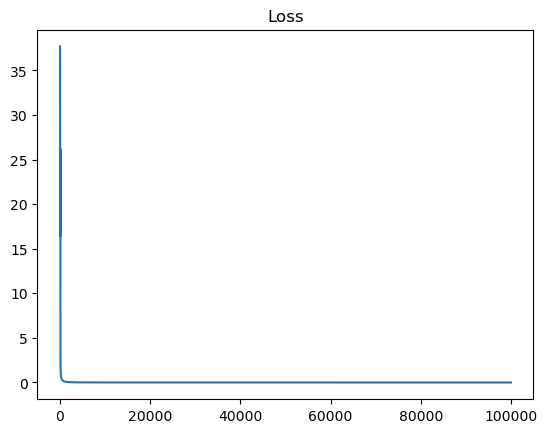

[[9.99999991e-01]
 [9.99999990e-01]
 [9.61170068e-08]
 [9.99999991e-01]
 [9.99999990e-01]
 [9.99999991e-01]
 [9.99999991e-01]
 [9.99999990e-01]
 [2.05979588e-07]
 [8.50337713e-08]
 [9.99999991e-01]
 [9.99999991e-01]
 [9.99935214e-01]
 [6.87176996e-08]
 [9.99999991e-01]
 [9.99999991e-01]
 [9.99999990e-01]
 [9.99999963e-01]
 [1.28724731e-07]
 [9.99999598e-01]
 [9.99999990e-01]
 [9.99999991e-01]
 [9.99999973e-01]
 [1.00779137e-07]
 [9.99999990e-01]
 [2.57598248e-07]
 [8.98148742e-03]
 [9.99999967e-01]
 [7.80627083e-08]
 [6.82918472e-08]
 [1.36126023e-03]
 [6.83632879e-08]
 [1.38443284e-04]
 [7.11545733e-08]
 [6.90716695e-08]
 [1.29402472e-07]
 [9.99999989e-01]
 [6.95410227e-08]
 [9.07154813e-08]
 [1.48724151e-07]
 [1.19422674e-04]
 [9.99999975e-01]
 [7.79946767e-03]
 [7.84740630e-08]
 [6.77790182e-08]
 [1.00414259e-04]
 [9.99999989e-01]
 [1.35647329e-01]
 [9.99999925e-01]
 [9.99999991e-01]
 [8.37236099e-08]
 [6.90573887e-08]
 [1.90155944e-07]
 [1.14738332e-06]
 [9.99999991e-01]
 [6.828531

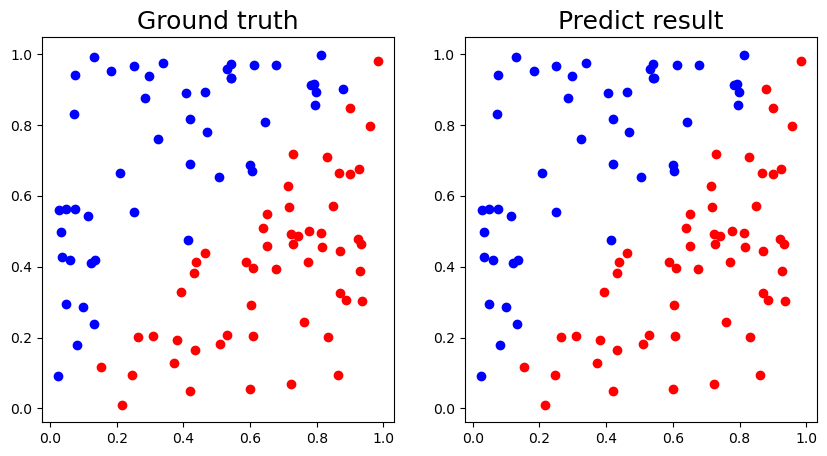

Iter: 0 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 2 |	 Ground truth: [0] |	 Predict: [9.61170068e-08]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 4 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 6 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 8 |	 Ground truth: [0] |	 Predict: [2.05979588e-07]
Iter: 9 |	 Ground truth: [0] |	 Predict: [8.50337713e-08]
Iter: 10 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 11 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99993521]
Iter: 13 |	 Ground truth: [0] |	 Predict: [6.87176996e-08]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 15 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99999999]
Iter: 17 |	 Ground truth: [1] |	 Predict: [0.99999996]
Iter

[37.68154314492127,
 25.249286974323294,
 25.824263229810015,
 27.195099592959288,
 28.459589214442186,
 29.79655784260101,
 27.70259763844168,
 28.147602314083752,
 26.982485523238076,
 26.92450798966851,
 26.216216073996037,
 26.025695947402806,
 25.633533610924086,
 25.47298428518325,
 25.27109414900175,
 25.170893710699826,
 25.071815452556645,
 25.016655937324536,
 24.968729995303267,
 24.9396184198479,
 24.915879817986916,
 24.900173044520944,
 24.887486248362244,
 24.87818030041596,
 24.87033078944142,
 24.863817884726206,
 24.857870067168776,
 24.852326473684247,
 24.846855414240768,
 24.841331084798295,
 24.83559098822866,
 24.829538481635893,
 24.823073100767928,
 24.816110197961358,
 24.80856589818694,
 24.800352978759143,
 24.791382098635243,
 24.781551733718466,
 24.770753191311044,
 24.75885954894573,
 24.74573032666698,
 24.731200370475793,
 24.715082666985353,
 24.697156791392047,
 24.677168998870698,
 24.654819255012118,
 24.629757615220242,
 24.601568295884523,
 24.56

In [7]:
Traning_and_Test(NN1, generate_linear)

epoch 0, loss: 8.643423164798612
epoch 5000, loss: 0.015795834091291063
epoch 10000, loss: 0.002667890414145507
epoch 15000, loss: 0.0013228866720179655
epoch 20000, loss: 0.0008534387770769016
epoch 25000, loss: 0.0006208481010827087
epoch 30000, loss: 0.00048379309432342575
epoch 35000, loss: 0.0003941490518873855
epoch 40000, loss: 0.0003312698895324351
epoch 45000, loss: 0.00028489642887238794
epoch 50000, loss: 0.00024938051118725914
epoch 55000, loss: 0.0002213673972869866
epoch 60000, loss: 0.00019874434762226186
epoch 65000, loss: 0.0001801172986824345
epoch 70000, loss: 0.00016453074226315155
epoch 75000, loss: 0.00015130872016219378
epoch 80000, loss: 0.00013996008805174502
epoch 85000, loss: 0.0001301197268082063
epoch 90000, loss: 0.00012151077321368891
epoch 95000, loss: 0.00011391961719093716
epoch 100000, loss: 0.0001071789123944823


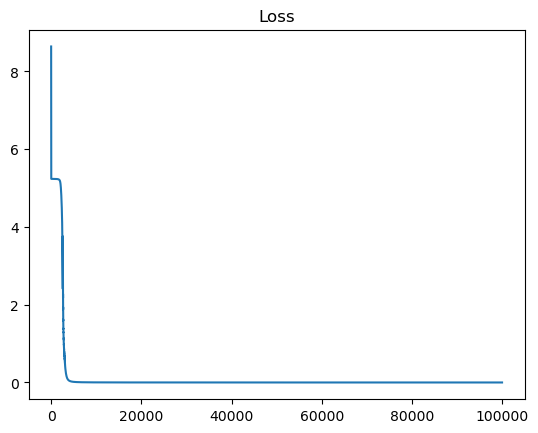

[[2.19592079e-05]
 [9.99993325e-01]
 [1.55420342e-04]
 [9.99992900e-01]
 [9.35855633e-04]
 [9.99991854e-01]
 [3.00211035e-03]
 [9.99983153e-01]
 [4.47078051e-03]
 [9.94524198e-01]
 [3.59892972e-03]
 [2.01317715e-03]
 [9.94613226e-01]
 [9.77376833e-04]
 [9.99980391e-01]
 [4.77019702e-04]
 [9.99988444e-01]
 [2.52248522e-04]
 [9.99988126e-01]
 [1.48282665e-04]
 [9.99986884e-01]]
Accuracy: 1.0


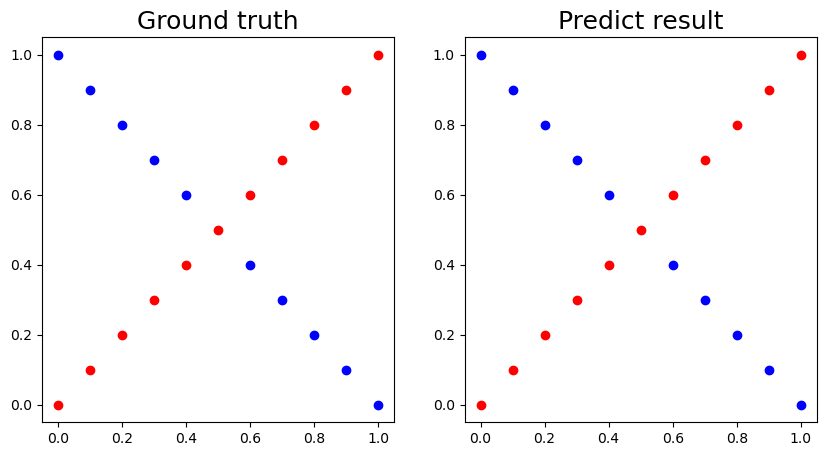

Iter: 0 |	 Ground truth: [0] |	 Predict: [2.19592079e-05]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99999333]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.00015542]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.9999929]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00093586]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99999185]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.00300211]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99998315]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.00447078]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.9945242]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.00359893]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.00201318]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99461323]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00097738]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99998039]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.00047702]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99998844]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.00025225]
Iter: 18 |	 Ground

[8.643423164798612,
 7.704567595967673,
 6.513566604870883,
 5.590101149450902,
 5.288388984375537,
 5.243907122622235,
 5.238792992142064,
 5.238210996055422,
 5.238143346028067,
 5.238134567235215,
 5.238132556012312,
 5.238131323598732,
 5.2381301803943074,
 5.238129046938603,
 5.2381279140717405,
 5.238126780735782,
 5.2381256468065125,
 5.238124512267295,
 5.23812337711387,
 5.238122241343397,
 5.238121104953189,
 5.23811996794058,
 5.238118830302898,
 5.23811769203747,
 5.238116553141618,
 5.238115413612661,
 5.238114273447912,
 5.2381131326446875,
 5.238111991200295,
 5.23811084911204,
 5.23810970637722,
 5.23810856299314,
 5.238107418957088,
 5.238106274266356,
 5.238105128918234,
 5.238103982910006,
 5.238102836238947,
 5.23810168890234,
 5.2381005408974515,
 5.238099392221553,
 5.238098242871913,
 5.238097092845789,
 5.23809594214044,
 5.23809479075312,
 5.238093638681081,
 5.238092485921567,
 5.238091332471825,
 5.238090178329091,
 5.2380890234905975,
 5.23808786795358,
 5.2

In [8]:
Traning_and_Test(NN1, generate_XOR_easy)

# Different Learning Rate

epoch 0, loss: 34.100579782724665
epoch 5000, loss: 0.007716927277749175
epoch 10000, loss: 0.002884887664002107
epoch 15000, loss: 0.0016741001279189606
epoch 20000, loss: 0.0011510637099130092
epoch 25000, loss: 0.0008657306972663384
epoch 30000, loss: 0.000688218458957063
epoch 35000, loss: 0.0005680412815280958
epoch 40000, loss: 0.00048173300625301447
epoch 45000, loss: 0.00041698837804717806
epoch 50000, loss: 0.00036676633209416123
epoch 55000, loss: 0.00032676204694647104
epoch 60000, loss: 0.00029420291940549295
epoch 65000, loss: 0.00026722651186800834
epoch 70000, loss: 0.00024453762095851157
epoch 75000, loss: 0.00022520891612271037
epoch 80000, loss: 0.00020855979601616664
epoch 85000, loss: 0.00019407996099866817
epoch 90000, loss: 0.00018137961823613895
epoch 95000, loss: 0.00017015611883891728
epoch 100000, loss: 0.00016017104987193386


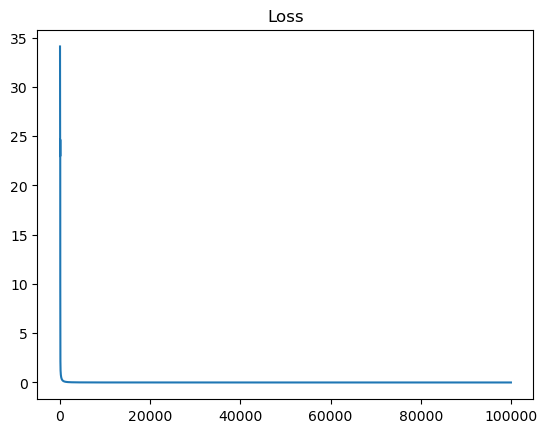

[[9.83965951e-01]
 [9.99999198e-01]
 [9.99999124e-01]
 [9.99997718e-01]
 [9.99997024e-01]
 [9.99999195e-01]
 [9.99999118e-01]
 [9.99998893e-01]
 [9.99999158e-01]
 [9.99997965e-01]
 [9.99998634e-01]
 [2.47322381e-07]
 [9.99999099e-01]
 [9.99999183e-01]
 [9.99999140e-01]
 [3.61976437e-07]
 [9.99919999e-01]
 [9.99999006e-01]
 [1.06410304e-06]
 [9.99999197e-01]
 [9.99998690e-01]
 [2.55654006e-07]
 [5.03501250e-07]
 [9.99954457e-01]
 [2.90091575e-07]
 [2.50580616e-07]
 [4.49501055e-07]
 [9.99998934e-01]
 [9.99998255e-01]
 [9.99999115e-01]
 [9.99998660e-01]
 [9.99998953e-01]
 [4.54317868e-07]
 [9.99998526e-01]
 [9.99999040e-01]
 [2.42391718e-05]
 [9.99999204e-01]
 [1.44603278e-06]
 [1.55630288e-05]
 [9.99998201e-01]
 [9.99975089e-01]
 [2.84894410e-07]
 [9.99998658e-01]
 [9.99949335e-01]
 [9.99999131e-01]
 [9.99999096e-01]
 [3.71305064e-07]
 [6.02104029e-04]
 [3.61633319e-07]
 [1.21462883e-06]
 [5.45155389e-05]
 [9.99997213e-01]
 [9.99998752e-01]
 [2.68764703e-07]
 [9.99999141e-01]
 [2.828707

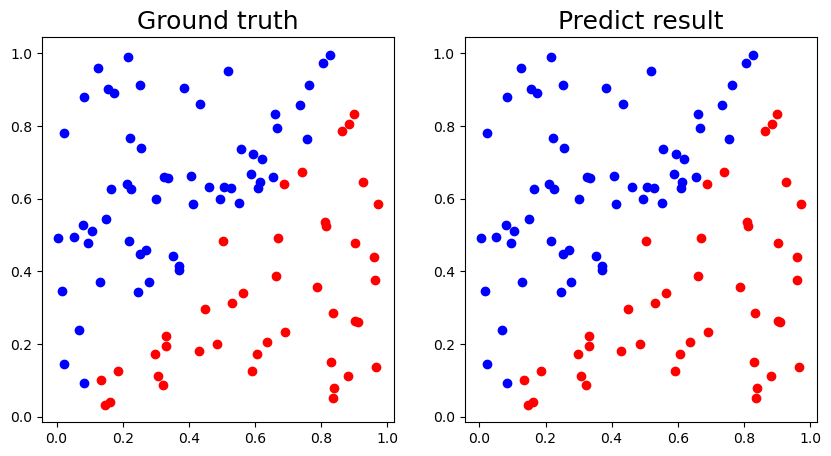

Iter: 0 |	 Ground truth: [1] |	 Predict: [0.98396595]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.9999992]
Iter: 2 |	 Ground truth: [1] |	 Predict: [0.99999912]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99999772]
Iter: 4 |	 Ground truth: [1] |	 Predict: [0.99999702]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.9999992]
Iter: 6 |	 Ground truth: [1] |	 Predict: [0.99999912]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99999889]
Iter: 8 |	 Ground truth: [1] |	 Predict: [0.99999916]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99999797]
Iter: 10 |	 Ground truth: [1] |	 Predict: [0.99999863]
Iter: 11 |	 Ground truth: [0] |	 Predict: [2.47322381e-07]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.9999991]
Iter: 13 |	 Ground truth: [1] |	 Predict: [0.99999918]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99999914]
Iter: 15 |	 Ground truth: [0] |	 Predict: [3.61976437e-07]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99992]
Iter: 17 |	 Ground truth: [1] |	 Predict: [0.99999901]
Iter: 18 |	 Ground

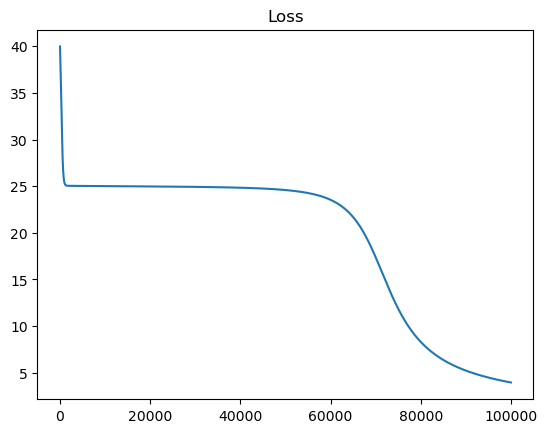

[[0.71210156]
 [0.06280945]
 [0.26041142]
 [0.25157056]
 [0.29399562]
 [0.17014728]
 [0.98475828]
 [0.07875638]
 [0.67888906]
 [0.04009379]
 [0.10620856]
 [0.59727354]
 [0.02607007]
 [0.71048652]
 [0.89398088]
 [0.321211  ]
 [0.95331558]
 [0.97410558]
 [0.11571849]
 [0.04890853]
 [0.50241379]
 [0.88438765]
 [0.59019979]
 [0.92523259]
 [0.9806502 ]
 [0.42570776]
 [0.23264853]
 [0.97561227]
 [0.92900781]
 [0.06105179]
 [0.39878976]
 [0.9717584 ]
 [0.96858913]
 [0.30993291]
 [0.98264337]
 [0.97875729]
 [0.97338827]
 [0.98094438]
 [0.05661159]
 [0.22365907]
 [0.84001201]
 [0.81571781]
 [0.9556163 ]
 [0.0522846 ]
 [0.41529428]
 [0.02252111]
 [0.05233395]
 [0.41575065]
 [0.0784622 ]
 [0.08193908]
 [0.98531242]
 [0.04856782]
 [0.91807225]
 [0.97692021]
 [0.98353849]
 [0.93376955]
 [0.08061378]
 [0.24164684]
 [0.38574688]
 [0.09703107]
 [0.92937631]
 [0.34987375]
 [0.79808977]
 [0.81038839]
 [0.51304484]
 [0.28278218]
 [0.98092788]
 [0.16164607]
 [0.98427945]
 [0.30964596]
 [0.97700547]
 [0.70

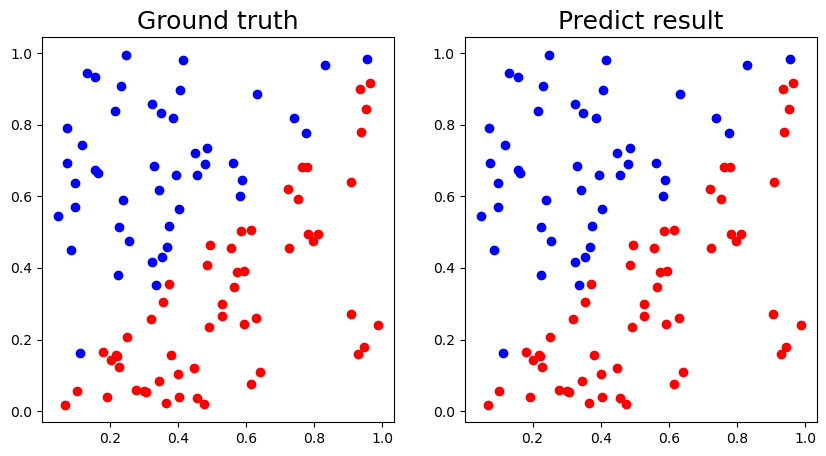

Iter: 0 |	 Ground truth: [1] |	 Predict: [0.71210156]
Iter: 1 |	 Ground truth: [0] |	 Predict: [0.06280945]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.26041142]
Iter: 3 |	 Ground truth: [0] |	 Predict: [0.25157056]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.29399562]
Iter: 5 |	 Ground truth: [0] |	 Predict: [0.17014728]
Iter: 6 |	 Ground truth: [1] |	 Predict: [0.98475828]
Iter: 7 |	 Ground truth: [0] |	 Predict: [0.07875638]
Iter: 8 |	 Ground truth: [1] |	 Predict: [0.67888906]
Iter: 9 |	 Ground truth: [0] |	 Predict: [0.04009379]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.10620856]
Iter: 11 |	 Ground truth: [1] |	 Predict: [0.59727354]
Iter: 12 |	 Ground truth: [0] |	 Predict: [0.02607007]
Iter: 13 |	 Ground truth: [1] |	 Predict: [0.71048652]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.89398088]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.321211]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.95331558]
Iter: 17 |	 Ground truth: [1] |	 Predict: [0.97410558]
Iter: 18 |	 Ground tru

In [9]:
loss1 = Traning_and_Test(NN1, generate_linear, lr = 0.1)
loss2 = Traning_and_Test(NN1, generate_linear, lr = 0.0001)

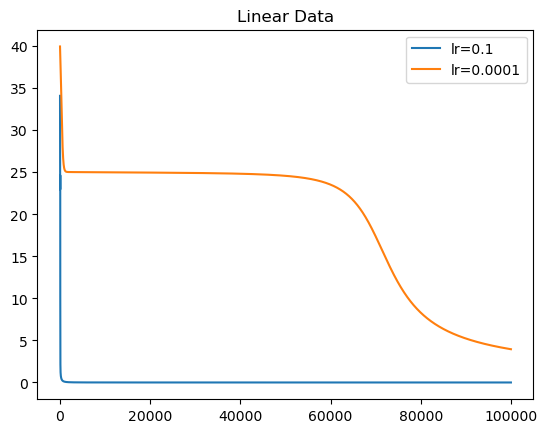

In [10]:
plt.plot(loss1, label='lr=0.1')
plt.plot(loss2, label='lr=0.0001')
plt.title('Linear Data')
plt.legend()
plt.show()

epoch 0, loss: 6.779376660130793
epoch 5000, loss: 0.5889612795641109
epoch 10000, loss: 0.004285807213347093
epoch 15000, loss: 0.0017224794406727776
epoch 20000, loss: 0.001033814835341333
epoch 25000, loss: 0.000725580064699379
epoch 30000, loss: 0.0005535655476522058
epoch 35000, loss: 0.00044479864713986686
epoch 40000, loss: 0.00037024246876086694
epoch 45000, loss: 0.0003161640723795554
epoch 50000, loss: 0.0002752633936664459
epoch 55000, loss: 0.00024331672792701607
epoch 60000, loss: 0.00021771764526535138
epoch 65000, loss: 0.00019677403292085675
epoch 70000, loss: 0.00017934137325037588
epoch 75000, loss: 0.00016461887325674442
epoch 80000, loss: 0.00015203007311071748
epoch 85000, loss: 0.0001411498237762347
epoch 90000, loss: 0.0001316579494919851
epoch 95000, loss: 0.00012330889836276087
epoch 100000, loss: 0.00011591131066303796


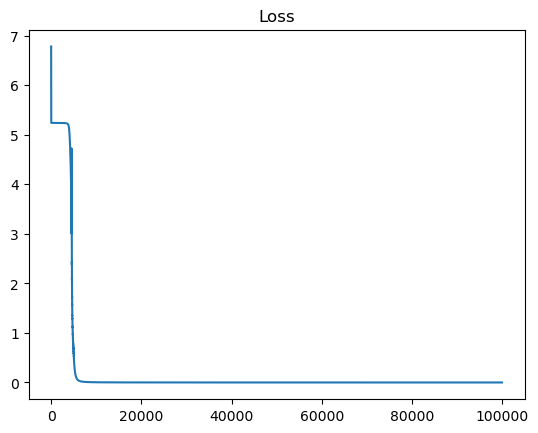

[[3.52958435e-05]
 [9.99983986e-01]
 [2.03063741e-04]
 [9.99984642e-01]
 [1.06019484e-03]
 [9.99984352e-01]
 [3.19361005e-03]
 [9.99973738e-01]
 [4.66806126e-03]
 [9.94439839e-01]
 [3.76825023e-03]
 [2.14940946e-03]
 [9.94395450e-01]
 [1.08087525e-03]
 [9.99975359e-01]
 [5.52774498e-04]
 [9.99986581e-01]
 [3.07890615e-04]
 [9.99987864e-01]
 [1.90506983e-04]
 [9.99988328e-01]]
Accuracy: 1.0


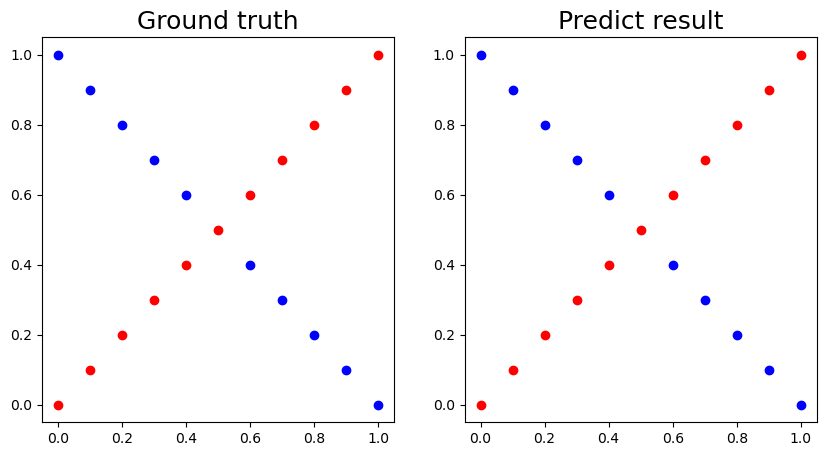

Iter: 0 |	 Ground truth: [0] |	 Predict: [3.52958435e-05]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99998399]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.00020306]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99998464]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00106019]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99998435]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.00319361]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99997374]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.00466806]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99443984]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.00376825]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.00214941]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99439545]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00108088]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99997536]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.00055277]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99998658]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.00030789]
Iter: 18 |	 Grou

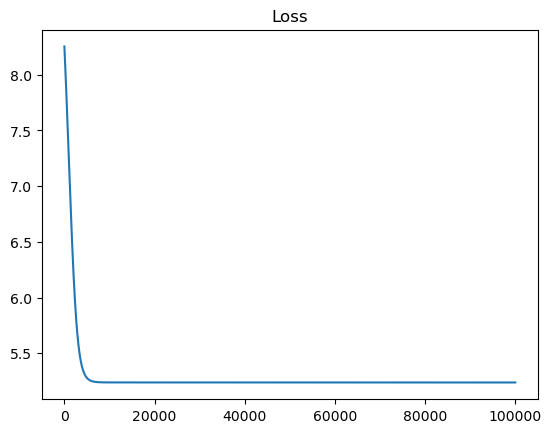

[[0.47675884]
 [0.47702317]
 [0.47681767]
 [0.47701249]
 [0.47687249]
 [0.47700156]
 [0.47691815]
 [0.47699041]
 [0.47695071]
 [0.47697908]
 [0.4769676 ]
 [0.47696764]
 [0.476956  ]
 [0.47695087]
 [0.47694434]
 [0.47691832]
 [0.47693265]
 [0.47687172]
 [0.47692097]
 [0.47681322]
 [0.47690933]]
Accuracy: 0.5238095238095238


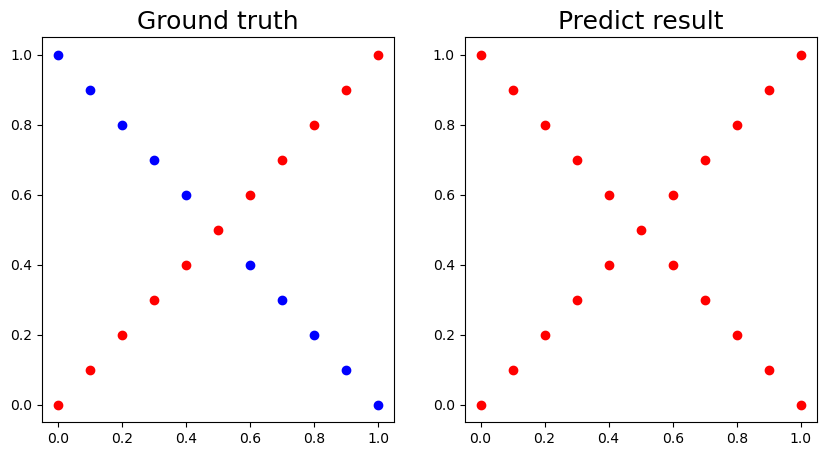

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.47675884]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.47702317]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.47681767]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.47701249]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.47687249]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.47700156]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.47691815]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.47699041]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.47695071]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.47697908]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.4769676]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.47696764]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.476956]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.47695087]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.47694434]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.47691832]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.47693265]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.47687172]
Iter: 18 |	 Ground trut

In [11]:
loss1 = Traning_and_Test(NN1, generate_XOR_easy, lr = 0.1)
loss2 = Traning_and_Test(NN1, generate_XOR_easy, lr = 0.0001)

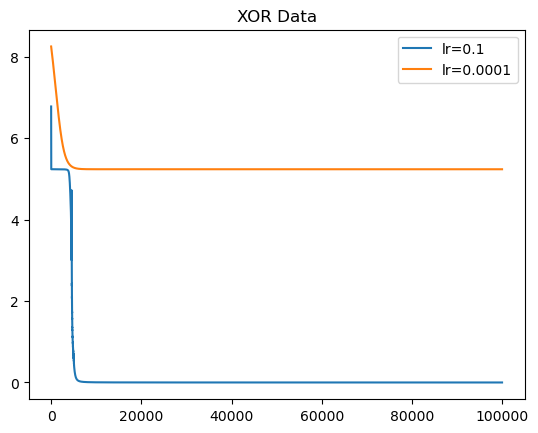

In [12]:
plt.plot(loss1, label='lr=0.1')
plt.plot(loss2, label='lr=0.0001')
plt.title('XOR Data')
plt.legend()
plt.show()

# Difference numbers of hidden units

epoch 0, loss: 28.881285679365963
epoch 5000, loss: 0.011339227271467947
epoch 10000, loss: 0.003908639537461488
epoch 15000, loss: 0.0022241787425280606
epoch 20000, loss: 0.0015172720365285938
epoch 25000, loss: 0.0011366676353858863
epoch 30000, loss: 0.0009015924395399754
epoch 35000, loss: 0.0007431501234986755
epoch 40000, loss: 0.0006296930680258441
epoch 45000, loss: 0.0005447544984833171
epoch 50000, loss: 0.00047896343153479157
epoch 55000, loss: 0.0004266134305417988
epoch 60000, loss: 0.0003840402631549896
epoch 65000, loss: 0.00034878833488235
epoch 70000, loss: 0.0003191531153462914
epoch 75000, loss: 0.0002939160339859859
epoch 80000, loss: 0.0002721838308622068
epoch 85000, loss: 0.0002532874354452174
epoch 90000, loss: 0.0002367162074919419
epoch 95000, loss: 0.00022207394823588617
epoch 100000, loss: 0.0002090487372161766


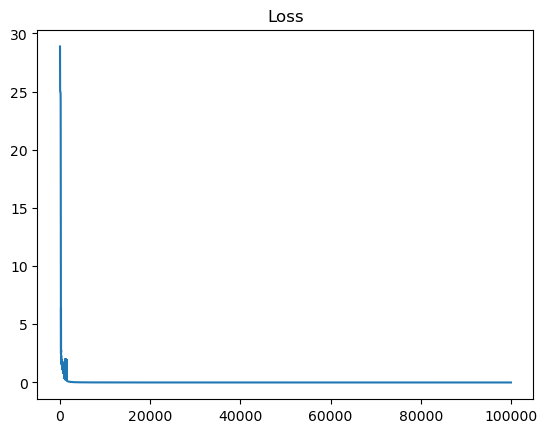

[[9.99998691e-01]
 [2.30721500e-06]
 [9.99999829e-01]
 [2.25872365e-06]
 [2.25905477e-06]
 [9.99999829e-01]
 [2.29026107e-06]
 [1.53309734e-04]
 [2.26146917e-06]
 [9.99999830e-01]
 [2.25829029e-06]
 [9.99999830e-01]
 [1.05878597e-05]
 [9.99999827e-01]
 [2.26711507e-06]
 [9.99999830e-01]
 [9.99999830e-01]
 [9.99999830e-01]
 [9.99999830e-01]
 [9.99999830e-01]
 [9.99999830e-01]
 [2.25831012e-06]
 [9.99999828e-01]
 [2.29632269e-06]
 [2.25835402e-06]
 [9.99999830e-01]
 [9.99999828e-01]
 [9.99999825e-01]
 [9.99999808e-01]
 [2.26205136e-06]
 [9.99999720e-01]
 [9.99999830e-01]
 [9.99999829e-01]
 [2.25852391e-06]
 [9.99999830e-01]
 [1.67528439e-03]
 [2.25881869e-06]
 [2.25829548e-06]
 [2.25854106e-06]
 [9.99999830e-01]
 [9.99999830e-01]
 [9.99999826e-01]
 [2.26554085e-06]
 [2.26695066e-06]
 [2.25852479e-06]
 [9.99999830e-01]
 [2.26575382e-06]
 [2.25839158e-06]
 [2.87227076e-06]
 [9.99999830e-01]
 [9.99999830e-01]
 [9.99999830e-01]
 [2.30513597e-06]
 [9.99999826e-01]
 [2.37504162e-06]
 [9.999998

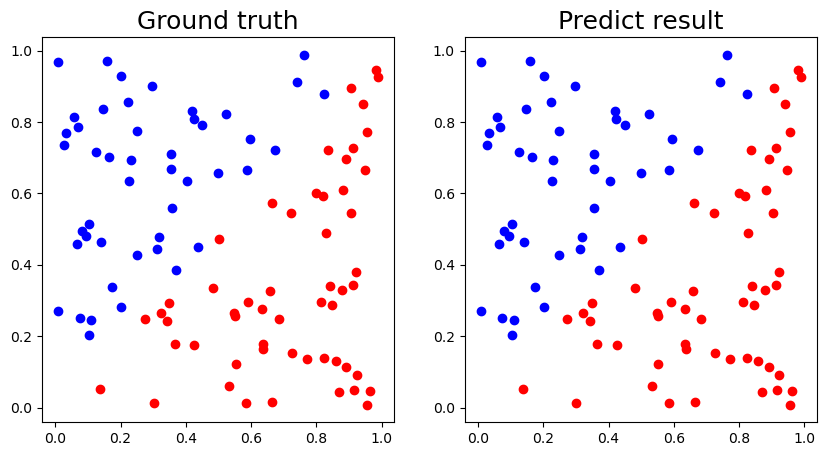

Iter: 0 |	 Ground truth: [1] |	 Predict: [0.99999869]
Iter: 1 |	 Ground truth: [0] |	 Predict: [2.307215e-06]
Iter: 2 |	 Ground truth: [1] |	 Predict: [0.99999983]
Iter: 3 |	 Ground truth: [0] |	 Predict: [2.25872365e-06]
Iter: 4 |	 Ground truth: [0] |	 Predict: [2.25905477e-06]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99999983]
Iter: 6 |	 Ground truth: [0] |	 Predict: [2.29026107e-06]
Iter: 7 |	 Ground truth: [0] |	 Predict: [0.00015331]
Iter: 8 |	 Ground truth: [0] |	 Predict: [2.26146917e-06]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99999983]
Iter: 10 |	 Ground truth: [0] |	 Predict: [2.25829029e-06]
Iter: 11 |	 Ground truth: [1] |	 Predict: [0.99999983]
Iter: 12 |	 Ground truth: [0] |	 Predict: [1.05878597e-05]
Iter: 13 |	 Ground truth: [1] |	 Predict: [0.99999983]
Iter: 14 |	 Ground truth: [0] |	 Predict: [2.26711507e-06]
Iter: 15 |	 Ground truth: [1] |	 Predict: [0.99999983]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99999983]
Iter: 17 |	 Ground truth: [1] |	 Predict: [0.

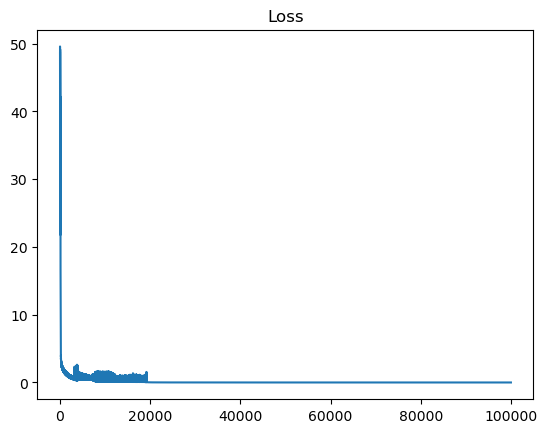

[[1.92934475e-20]
 [9.99999999e-01]
 [8.03328827e-18]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.93109201e-20]
 [1.00000000e+00]
 [9.99999999e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.92941101e-20]
 [1.00000000e+00]
 [1.92983181e-20]
 [1.00000000e+00]
 [1.93040977e-20]
 [2.67232671e-20]
 [1.92831395e-20]
 [1.47497672e-19]
 [9.99998377e-01]
 [1.93128404e-20]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.93256875e-20]
 [1.93081218e-20]
 [1.93355310e-20]
 [1.00000000e+00]
 [7.57487450e-18]
 [2.84237127e-17]
 [1.92969643e-20]
 [1.92954141e-20]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.95971039e-20]
 [3.93949826e-20]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.94277088e-20]
 [1.41494082e-17]
 [7.02618726e-20]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.96107423e-20]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99999999e-01]
 [1.00000000e+00]
 [1.93221845e-20]
 [1.93595132e-20]
 [1.00000000e+00]
 [1.93112386e-20]
 [1.93032457e-20]
 [9.99988822e-01]
 [2.25848140e-08]
 [1.952257

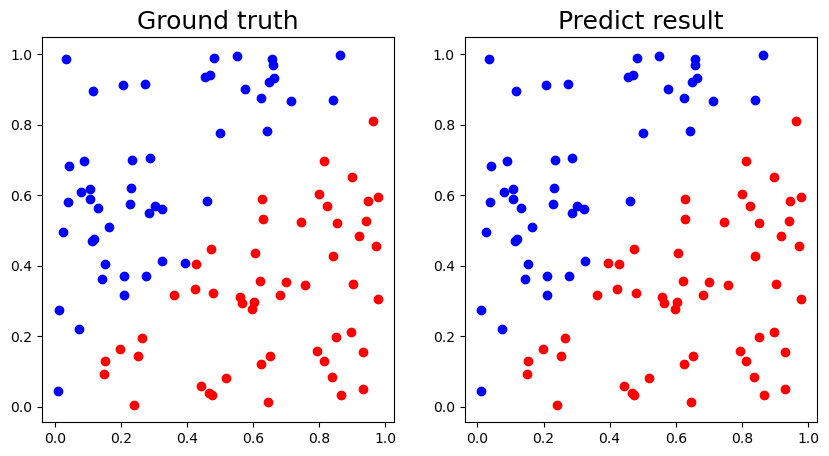

Iter: 0 |	 Ground truth: [0] |	 Predict: [1.92934475e-20]
Iter: 1 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 2 |	 Ground truth: [0] |	 Predict: [8.03328827e-18]
Iter: 3 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 4 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 5 |	 Ground truth: [0] |	 Predict: [1.93109201e-20]
Iter: 6 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 7 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 8 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 9 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 10 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 11 |	 Ground truth: [0] |	 Predict: [1.92941101e-20]
Iter: 12 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 13 |	 Ground truth: [0] |	 Predict: [1.92983181e-20]
Iter: 14 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 15 |	 Ground truth: [0] |	 Predict: [1.93040977e-20]
Iter: 16 |	 Ground truth: [0] |	 Predict: [2.67232671e-20]
Iter: 17 |	 Ground truth: [0] |	 Predict: [1.92831395e-20]
Iter: 18 |	 Ground truth: [0] |	 Predict: [1.47497672e-19]
Iter: 19 

In [13]:
loss1 = Traning_and_Test(NN1, generate_linear, n_hidden=2)
loss2 = Traning_and_Test(NN1, generate_linear, n_hidden=8)

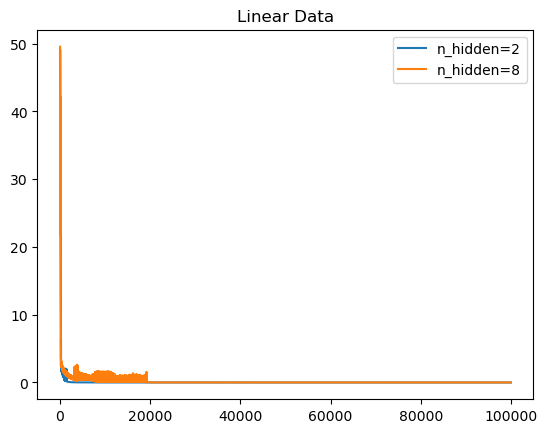

In [14]:
plt.plot(loss1, label='n_hidden=2')
plt.plot(loss2, label='n_hidden=8')
plt.title('Linear Data')
plt.legend()
plt.show()

epoch 0, loss: 5.807445673123024
epoch 5000, loss: 5.238167628961389
epoch 10000, loss: 5.238058816363509
epoch 15000, loss: 5.237952740918214
epoch 20000, loss: 5.23610758991376
epoch 25000, loss: 0.2832129969826716
epoch 30000, loss: 0.10359842095939047
epoch 35000, loss: 0.06284856424593577
epoch 40000, loss: 0.04488326203858407
epoch 45000, loss: 0.03481051723959694
epoch 50000, loss: 0.0283834376742414
epoch 55000, loss: 0.0239340517930306
epoch 60000, loss: 0.020675270890777028
epoch 65000, loss: 0.0181878190176074
epoch 70000, loss: 0.016228128539402926
epoch 75000, loss: 0.014645155471073933
epoch 80000, loss: 0.013340323085238312
epoch 85000, loss: 0.012246596923459386
epoch 90000, loss: 0.011316823980348525
epoch 95000, loss: 0.010516883159786133
epoch 100000, loss: 0.00982148177357037


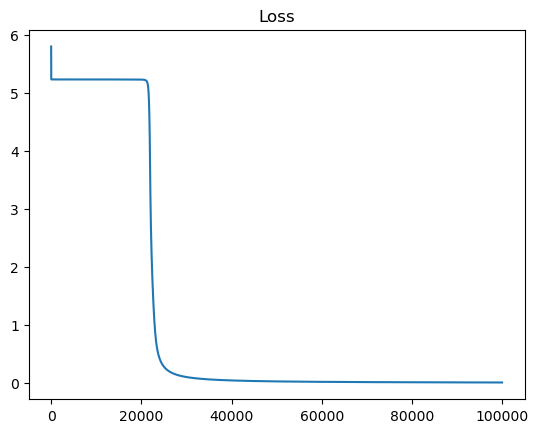

[[6.87165038e-02]
 [9.69119617e-01]
 [9.17239243e-03]
 [9.69133585e-01]
 [1.22616531e-03]
 [9.69403957e-01]
 [2.20044208e-04]
 [9.73499167e-01]
 [6.65515231e-05]
 [9.86643910e-01]
 [3.96126949e-05]
 [4.88358448e-05]
 [9.68507216e-01]
 [1.15682374e-04]
 [9.92925861e-01]
 [4.38788381e-04]
 [9.93422468e-01]
 [2.12543443e-03]
 [9.93445066e-01]
 [1.07155701e-02]
 [9.93446129e-01]]
Accuracy: 1.0


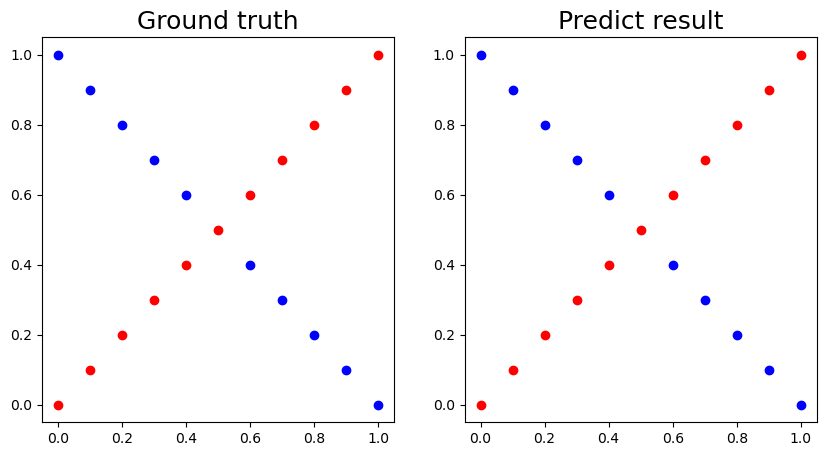

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.0687165]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.96911962]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.00917239]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.96913358]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00122617]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.96940396]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.00022004]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.97349917]
Iter: 8 |	 Ground truth: [0] |	 Predict: [6.65515231e-05]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.98664391]
Iter: 10 |	 Ground truth: [0] |	 Predict: [3.96126949e-05]
Iter: 11 |	 Ground truth: [0] |	 Predict: [4.88358448e-05]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.96850722]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00011568]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99292586]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.00043879]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99342247]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.00212543]
Iter: 18 

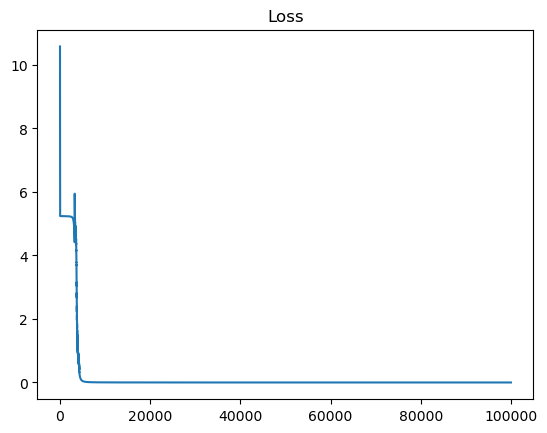

[[7.38001331e-06]
 [9.99999807e-01]
 [5.17128254e-05]
 [9.99999783e-01]
 [4.31280433e-04]
 [9.99999680e-01]
 [2.10985433e-03]
 [9.99998447e-01]
 [4.27924725e-03]
 [9.95001167e-01]
 [4.08048694e-03]
 [2.47997834e-03]
 [9.95241676e-01]
 [1.25746434e-03]
 [9.99993876e-01]
 [6.30506395e-04]
 [9.99996489e-01]
 [3.39310662e-04]
 [9.99996426e-01]
 [2.01212365e-04]
 [9.99996285e-01]]
Accuracy: 1.0


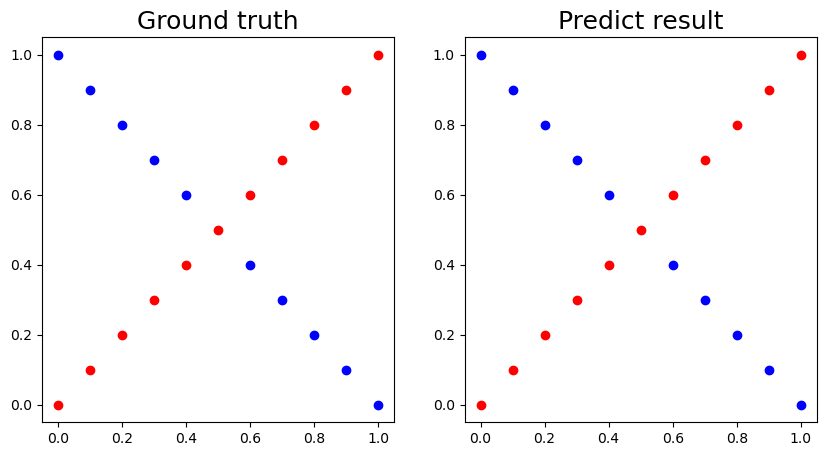

Iter: 0 |	 Ground truth: [0] |	 Predict: [7.38001331e-06]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99999981]
Iter: 2 |	 Ground truth: [0] |	 Predict: [5.17128254e-05]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99999978]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00043128]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99999968]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.00210985]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99999845]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.00427925]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99500117]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.00408049]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.00247998]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99524168]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00125746]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99999388]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.00063051]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99999649]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.00033931]
Iter: 18 |	 

In [15]:
loss1 = Traning_and_Test(NN1, generate_XOR_easy, n_hidden=2)
loss2 = Traning_and_Test(NN1, generate_XOR_easy, n_hidden=8)

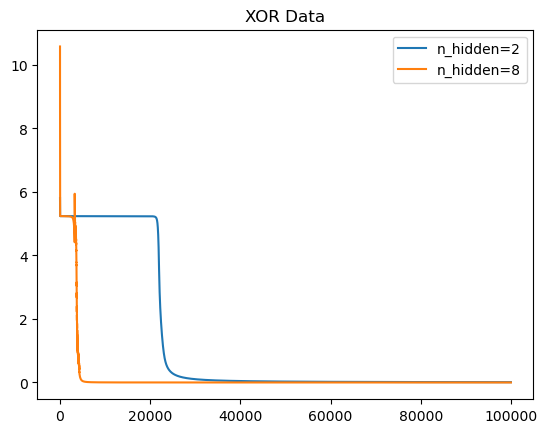

In [16]:
plt.plot(loss1, label='n_hidden=2')
plt.plot(loss2, label='n_hidden=8')
plt.title('XOR Data')
plt.legend()
plt.show()

In [17]:
class NN_wo_activation:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.lr = lr
        self.optimizer = SGD([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.a2 = self.weights2.forward(self.a1)
        self.a3 = self.weights3.forward(self.a2)
        return self.a3
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.weights3.backward(dloss_dy)
        da2_da1 = self.weights2.backward(dou_da3)
        da1_dw1 = self.weights1.backward(da2_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

epoch 0, loss: 544.0217529006682
epoch 5000, loss: 13.068782521706408
epoch 10000, loss: 13.068782521706408
epoch 15000, loss: 13.068782521706408
epoch 20000, loss: 13.068782521706408
epoch 25000, loss: 13.068782521706408
epoch 30000, loss: 13.068782521706408
epoch 35000, loss: 13.068782521706408
epoch 40000, loss: 13.068782521706408
epoch 45000, loss: 13.068782521706408
epoch 50000, loss: 13.068782521706408
epoch 55000, loss: 13.068782521706408
epoch 60000, loss: 13.068782521706408
epoch 65000, loss: 13.068782521706408
epoch 70000, loss: 13.068782521706408
epoch 75000, loss: 13.068782521706408
epoch 80000, loss: 13.068782521706408
epoch 85000, loss: 13.068782521706408
epoch 90000, loss: 13.068782521706408
epoch 95000, loss: 13.068782521706408
epoch 100000, loss: 13.068782521706408


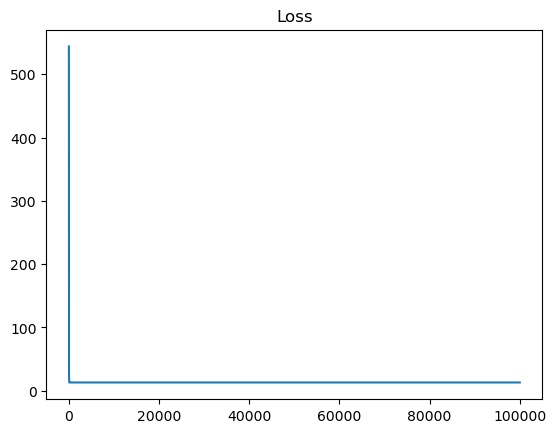

[[ 0.64862488]
 [ 0.72064037]
 [ 0.21269248]
 [ 0.79896146]
 [-0.49806029]
 [ 0.03470409]
 [ 0.51193154]
 [ 0.85098799]
 [ 0.5920651 ]
 [-0.33314946]
 [ 1.39041972]
 [-0.22516162]
 [ 1.04616301]
 [ 0.78072224]
 [ 0.39025533]
 [ 0.88190671]
 [-0.38828874]
 [ 0.15389775]
 [ 1.47540765]
 [-0.39780551]
 [ 0.05216085]
 [ 0.73583255]
 [-0.3347418 ]
 [ 0.61272158]
 [ 0.00543961]
 [ 0.684639  ]
 [-0.07249687]
 [-0.14629966]
 [ 0.37488768]
 [ 0.27849186]
 [ 1.00498117]
 [ 0.30843296]
 [ 0.48623166]
 [ 0.63765987]
 [ 0.1527904 ]
 [ 0.55640403]
 [ 0.33302048]
 [-0.10197173]
 [ 0.65514666]
 [ 1.04099079]
 [ 0.88453134]
 [ 0.22632667]
 [ 0.82962531]
 [ 0.79189251]
 [ 0.67501495]
 [-0.44597269]
 [ 0.82812913]
 [ 1.20767366]
 [ 0.52728676]
 [ 0.65489361]
 [ 1.02916902]
 [-0.30940198]
 [ 1.19254357]
 [ 0.65887576]
 [ 0.05441571]
 [ 0.82306066]
 [ 1.06199646]
 [ 0.20375812]
 [ 0.5155007 ]
 [ 0.75386006]
 [ 0.70093946]
 [ 0.34827105]
 [ 0.48602683]
 [ 1.17676529]
 [ 0.04467817]
 [ 0.01893518]
 [-0.18914

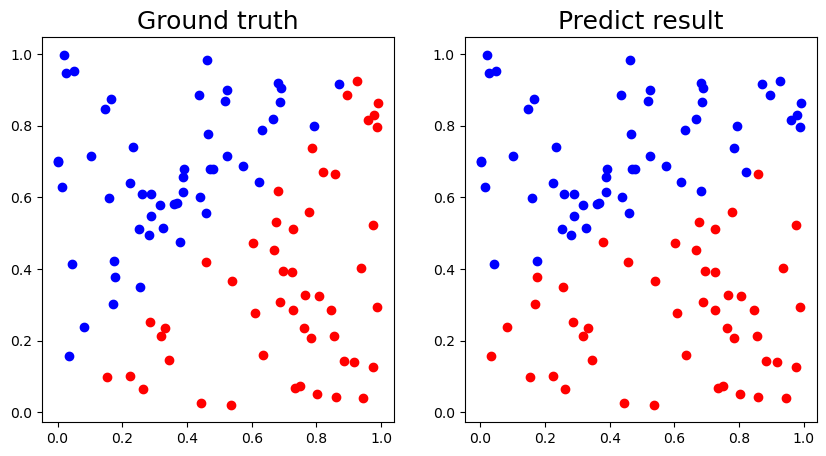

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.64862488]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.72064037]
Iter: 2 |	 Ground truth: [1] |	 Predict: [0.21269248]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.79896146]
Iter: 4 |	 Ground truth: [0] |	 Predict: [-0.49806029]
Iter: 5 |	 Ground truth: [0] |	 Predict: [0.03470409]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.51193154]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.85098799]
Iter: 8 |	 Ground truth: [1] |	 Predict: [0.5920651]
Iter: 9 |	 Ground truth: [0] |	 Predict: [-0.33314946]
Iter: 10 |	 Ground truth: [1] |	 Predict: [1.39041972]
Iter: 11 |	 Ground truth: [0] |	 Predict: [-0.22516162]
Iter: 12 |	 Ground truth: [1] |	 Predict: [1.04616301]
Iter: 13 |	 Ground truth: [1] |	 Predict: [0.78072224]
Iter: 14 |	 Ground truth: [0] |	 Predict: [0.39025533]
Iter: 15 |	 Ground truth: [1] |	 Predict: [0.88190671]
Iter: 16 |	 Ground truth: [0] |	 Predict: [-0.38828874]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.15389775]
Iter: 18 |	 Groun

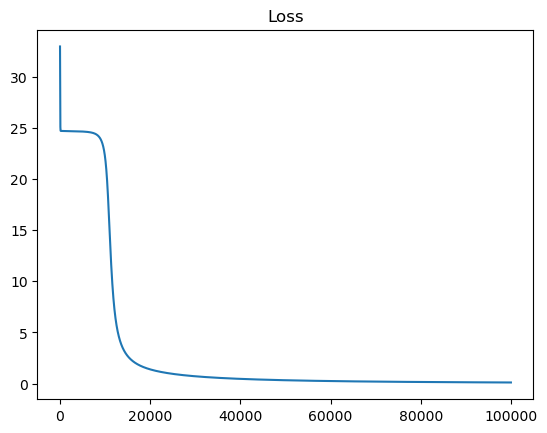

[[1.47419529e-04]
 [9.99961590e-01]
 [1.61472702e-04]
 [9.99958705e-01]
 [9.89532405e-04]
 [9.99963682e-01]
 [3.02012991e-04]
 [9.97435960e-01]
 [9.98974068e-01]
 [1.86803681e-04]
 [1.42494719e-04]
 [1.79615496e-04]
 [9.99935027e-01]
 [9.99938028e-01]
 [9.99965067e-01]
 [2.12000161e-04]
 [8.66992053e-01]
 [7.30178734e-03]
 [1.26555602e-04]
 [2.35344732e-04]
 [1.90354227e-04]
 [9.99879231e-01]
 [9.99956369e-01]
 [9.99938133e-01]
 [1.78246878e-04]
 [3.12173409e-04]
 [9.86633285e-01]
 [2.12892956e-04]
 [9.99957014e-01]
 [9.99875627e-01]
 [1.55965071e-04]
 [3.81170703e-04]
 [9.99957433e-01]
 [9.99954017e-01]
 [4.33193720e-03]
 [1.41559189e-04]
 [9.99965386e-01]
 [9.99964467e-01]
 [9.99951380e-01]
 [9.99829922e-01]
 [1.06613010e-01]
 [1.38249542e-04]
 [2.13809159e-04]
 [2.93595978e-04]
 [9.99925814e-01]
 [9.99964052e-01]
 [9.47527044e-01]
 [9.99957469e-01]
 [9.99962569e-01]
 [1.56183786e-01]
 [9.99946725e-01]
 [1.41058721e-04]
 [1.64566664e-04]
 [1.49939005e-04]
 [9.99787709e-01]
 [9.998770

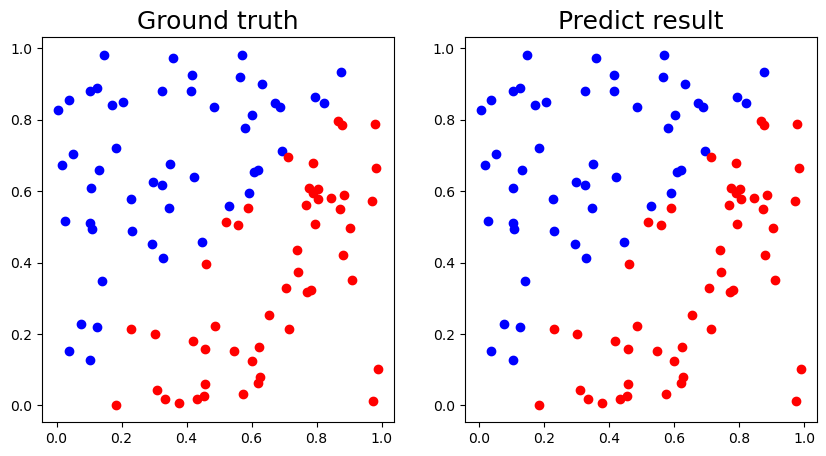

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.00014742]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99996159]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.00016147]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99995871]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00098953]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99996368]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.00030201]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99743596]
Iter: 8 |	 Ground truth: [1] |	 Predict: [0.99897407]
Iter: 9 |	 Ground truth: [0] |	 Predict: [0.0001868]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.00014249]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.00017962]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99993503]
Iter: 13 |	 Ground truth: [1] |	 Predict: [0.99993803]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99996507]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.000212]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.86699205]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.00730179]
Iter: 18 |	 Ground trut

In [18]:
loss1 = Traning_and_Test(NN_wo_activation, generate_linear, lr=0.001)
loss2 = Traning_and_Test(NN1, generate_linear, lr=0.001)

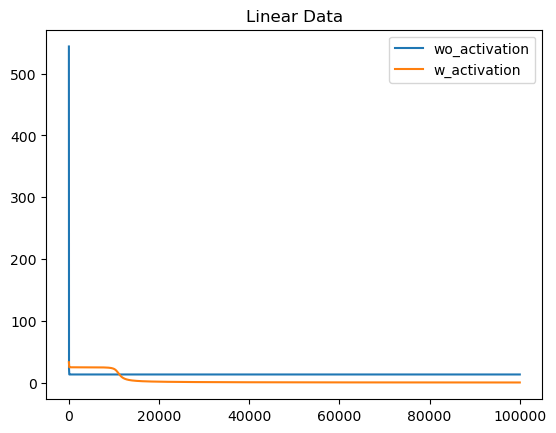

In [19]:
loss_cmp(loss1, loss2, 'wo_activation', 'w_activation', 'Linear Data')

epoch 0, loss: 48.694308657610584
epoch 5000, loss: 6.062992125984252
epoch 10000, loss: 6.062992125984252
epoch 15000, loss: 6.062992125984252
epoch 20000, loss: 6.062992125984252
epoch 25000, loss: 6.062992125984252
epoch 30000, loss: 6.062992125984252
epoch 35000, loss: 6.062992125984252
epoch 40000, loss: 6.062992125984252
epoch 45000, loss: 6.062992125984252
epoch 50000, loss: 6.062992125984252
epoch 55000, loss: 6.062992125984252
epoch 60000, loss: 6.062992125984252
epoch 65000, loss: 6.062992125984252
epoch 70000, loss: 6.062992125984252
epoch 75000, loss: 6.062992125984252
epoch 80000, loss: 6.062992125984252
epoch 85000, loss: 6.062992125984252
epoch 90000, loss: 6.062992125984252
epoch 95000, loss: 6.062992125984252
epoch 100000, loss: 6.062992125984252


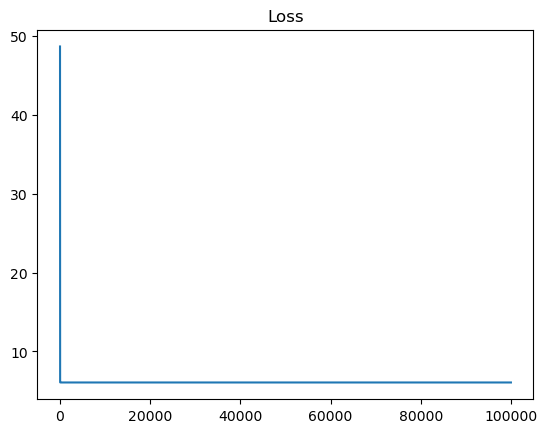

[[0.        ]
 [0.39370079]
 [0.07874016]
 [0.39370079]
 [0.15748031]
 [0.39370079]
 [0.23622047]
 [0.39370079]
 [0.31496063]
 [0.39370079]
 [0.39370079]
 [0.47244094]
 [0.39370079]
 [0.5511811 ]
 [0.39370079]
 [0.62992126]
 [0.39370079]
 [0.70866142]
 [0.39370079]
 [0.78740157]
 [0.39370079]]
Accuracy: 0.3333333333333333


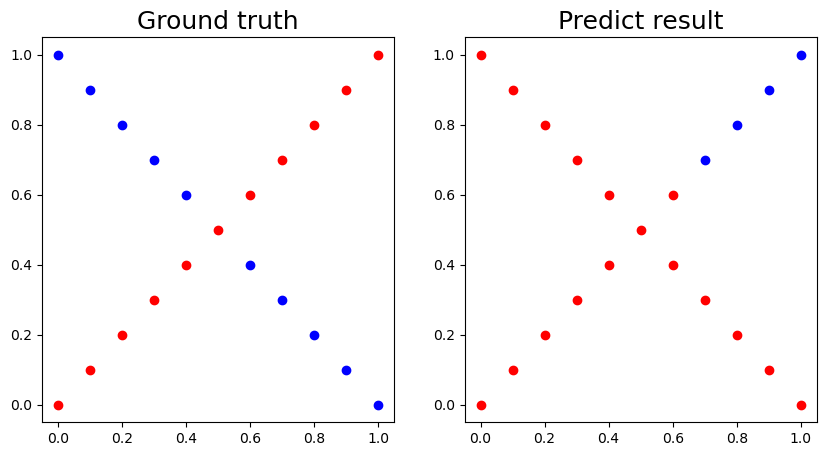

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.07874016]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.15748031]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.23622047]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.31496063]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.39370079]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.47244094]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.5511811]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.62992126]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.70866142]
Iter: 18 |	 Ground truth: [1]

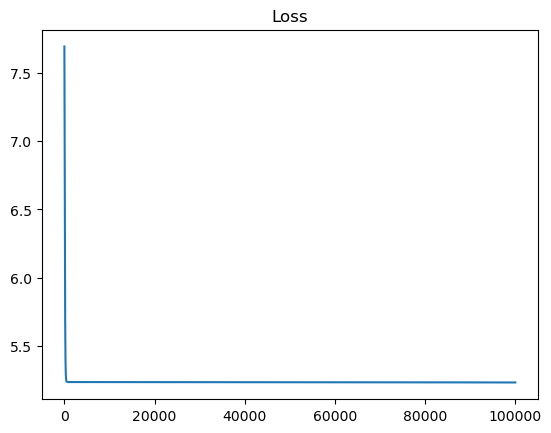

[[0.47743824]
 [0.47672444]
 [0.47760045]
 [0.4768845 ]
 [0.47768694]
 [0.47704689]
 [0.47770161]
 [0.47721143]
 [0.4776516 ]
 [0.47737794]
 [0.47754622]
 [0.47739588]
 [0.47771606]
 [0.47721108]
 [0.47788726]
 [0.47700167]
 [0.47805957]
 [0.47677637]
 [0.47823279]
 [0.47654255]
 [0.47840666]]
Accuracy: 0.5238095238095238


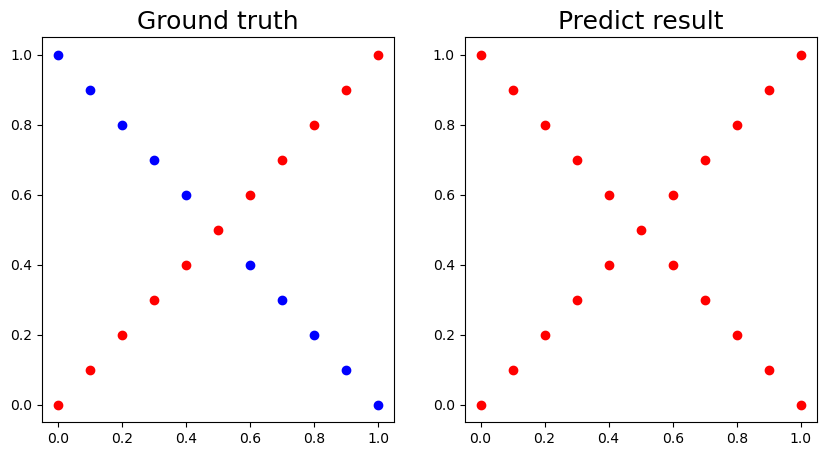

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.47743824]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.47672444]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.47760045]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.4768845]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.47768694]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.47704689]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.47770161]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.47721143]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.4776516]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.47737794]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.47754622]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.47739588]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.47771606]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.47721108]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.47788726]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.47700167]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.47805957]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.47677637]
Iter: 18 |	 Ground tru

In [20]:
loss1 = Traning_and_Test(NN_wo_activation, generate_XOR_easy, lr=0.001)
loss2 = Traning_and_Test(NN1, generate_XOR_easy, lr=0.001)

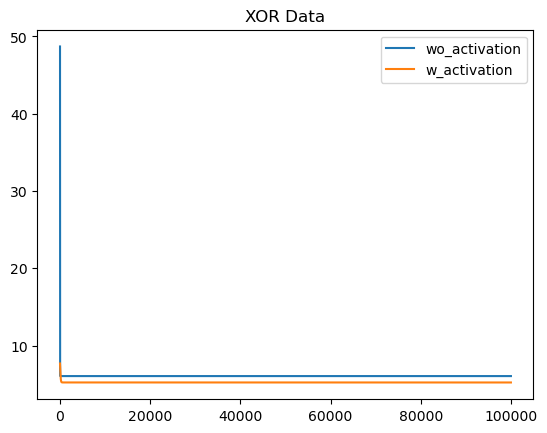

In [21]:
loss_cmp(loss1, loss2, 'wo_activation', 'w_activation', 'XOR Data')

In [22]:
class NN_relu:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.relu1 = ReLU()
        self.relu2 = ReLU()
        self.relu3 = ReLU()
        self.lr = lr
        self.optimizer = SGD([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.relu1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.relu2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.relu3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.relu3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.relu2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.relu1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

epoch 0, loss: 26.749063114738973
epoch 5000, loss: 10.010021601855065
epoch 10000, loss: 10.010010592881248
epoch 15000, loss: 10.010009215332706
epoch 20000, loss: 10.010009039138426
epoch 25000, loss: 10.010009016597094
epoch 30000, loss: 10.010009013713184
epoch 35000, loss: 10.010009013344217
epoch 40000, loss: 10.01000901329701
epoch 45000, loss: 10.010009013290974
epoch 50000, loss: 10.0100090132902
epoch 55000, loss: 10.010009013290102
epoch 60000, loss: 10.01000901329009
epoch 65000, loss: 10.010009013290087
epoch 70000, loss: 10.010009013290087
epoch 75000, loss: 10.010009013290087
epoch 80000, loss: 10.010009013290084
epoch 85000, loss: 10.010009013290086
epoch 90000, loss: 10.010009013290087
epoch 95000, loss: 10.010009013290087
epoch 100000, loss: 10.010009013290086


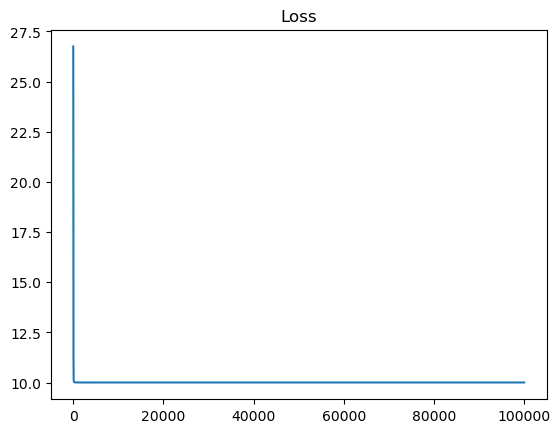

[[1.68418683e-01]
 [2.45755246e-01]
 [1.01280232e+00]
 [1.49955169e-01]
 [7.64175809e-02]
 [2.76801532e-01]
 [9.64225041e-01]
 [0.00000000e+00]
 [1.72080031e-02]
 [3.93103518e-01]
 [7.65543462e-01]
 [6.70552059e-01]
 [0.00000000e+00]
 [7.00173871e-03]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.41948054e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.05150349e+00]
 [0.00000000e+00]
 [1.95243455e-03]
 [7.25747185e-01]
 [1.02763961e+00]
 [5.09375176e-01]
 [7.16325582e-04]
 [3.07110440e-01]
 [3.08281094e-01]
 [2.59670310e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.39450485e-01]
 [1.43940462e+00]
 [4.06423508e-04]
 [1.11489424e+00]
 [6.22900404e-01]
 [6.97869328e-02]
 [3.70193080e-01]
 [8.93287146e-01]
 [1.29327939e-01]
 [0.00000000e+00]
 [7.44707963e-01]
 [2.85417216e-01]
 [7.82311689e-01]
 [3.34573955e-01]
 [9.71672649e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.19602358e+00]
 [7.06148119e-01]
 [0.00000000e+00]
 [1.16533431e-01]
 [1.27642916e-03]
 [5.67619553e-01]
 [0.000000

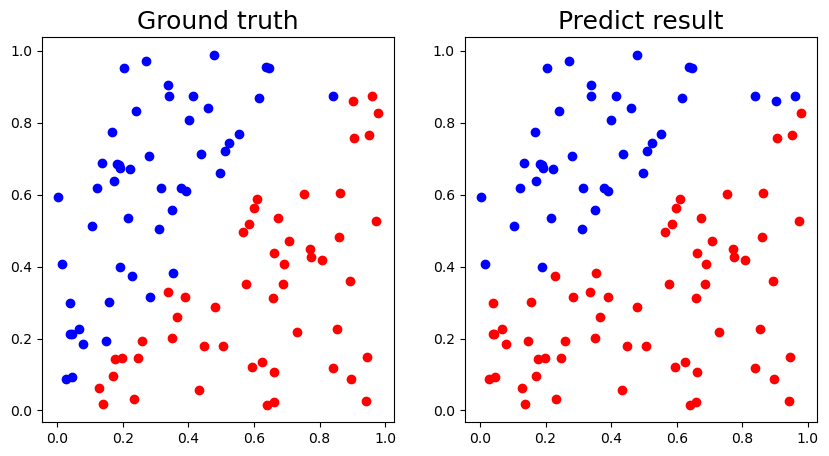

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.16841868]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.24575525]
Iter: 2 |	 Ground truth: [1] |	 Predict: [1.01280232]
Iter: 3 |	 Ground truth: [0] |	 Predict: [0.14995517]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.07641758]
Iter: 5 |	 Ground truth: [0] |	 Predict: [0.27680153]
Iter: 6 |	 Ground truth: [1] |	 Predict: [0.96422504]
Iter: 7 |	 Ground truth: [0] |	 Predict: [0.]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.017208]
Iter: 9 |	 Ground truth: [0] |	 Predict: [0.39310352]
Iter: 10 |	 Ground truth: [1] |	 Predict: [0.76554346]
Iter: 11 |	 Ground truth: [1] |	 Predict: [0.67055206]
Iter: 12 |	 Ground truth: [0] |	 Predict: [0.]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00700174]
Iter: 14 |	 Ground truth: [0] |	 Predict: [0.]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.]
Iter: 16 |	 Ground truth: [0] |	 Predict: [0.54194805]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.]
Iter: 18 |	 Ground truth: [0] |	 Predict: [0.]
Iter: 19 |	 Gro

In [23]:
loss1 = Traning_and_Test(NN_relu, generate_linear, lr=0.001)

epoch 0, loss: 28.9041106938773
epoch 5000, loss: 24.457009725293783
epoch 10000, loss: 24.39514170007856
epoch 15000, loss: 24.09618400633017
epoch 20000, loss: 4.128519867384458
epoch 25000, loss: 2.0268228465589737
epoch 30000, loss: 1.4780342132724347
epoch 35000, loss: 1.186943131606518
epoch 40000, loss: 0.999572564706018
epoch 45000, loss: 0.8676671648281086
epoch 50000, loss: 0.7691724347223977
epoch 55000, loss: 0.6921253528298769
epoch 60000, loss: 0.6294922203506609
epoch 65000, loss: 0.5769490979709896
epoch 70000, loss: 0.5317505099991374
epoch 75000, loss: 0.49210241178061154
epoch 80000, loss: 0.45679973933194695
epoch 85000, loss: 0.42501097753780354
epoch 90000, loss: 0.39614685423882984
epoch 95000, loss: 0.36977828069722346
epoch 100000, loss: 0.3455838289964931


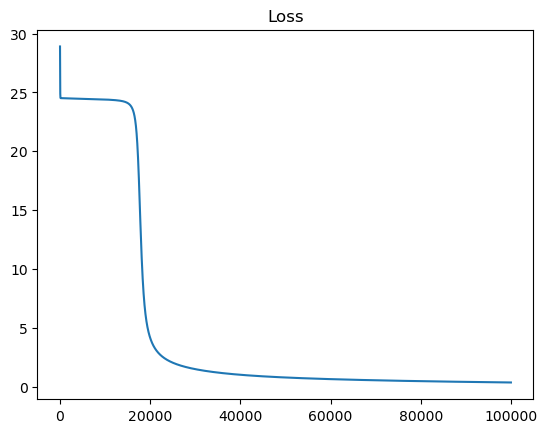

[[9.99962723e-01]
 [9.99984704e-01]
 [9.99849657e-01]
 [8.39298387e-05]
 [9.99975647e-01]
 [8.02692495e-01]
 [9.99975508e-01]
 [1.01303150e-04]
 [9.99919335e-01]
 [1.00228691e-03]
 [9.99979270e-01]
 [1.12254457e-04]
 [1.45427757e-04]
 [1.03296754e-03]
 [1.44412906e-01]
 [9.99980482e-01]
 [9.99982736e-01]
 [9.99978448e-01]
 [4.69440260e-01]
 [9.99983712e-01]
 [1.63764047e-04]
 [8.07874901e-04]
 [9.99983133e-01]
 [9.99876230e-01]
 [9.99923792e-01]
 [9.60030484e-05]
 [1.31123630e-04]
 [1.05490793e-04]
 [5.44360879e-03]
 [4.67100525e-04]
 [9.99954847e-01]
 [9.74763899e-02]
 [9.34986236e-05]
 [9.99963740e-01]
 [9.99939213e-01]
 [9.96851491e-01]
 [9.29867031e-05]
 [1.34886893e-04]
 [9.97909518e-01]
 [9.99980927e-01]
 [9.99696928e-01]
 [9.99980006e-01]
 [9.84235826e-01]
 [9.95972041e-01]
 [9.99979935e-01]
 [9.99950225e-01]
 [9.99975741e-01]
 [9.99983122e-01]
 [1.07523212e-04]
 [8.79333563e-05]
 [9.95329407e-01]
 [9.99984981e-01]
 [9.52424471e-05]
 [1.17289751e-04]
 [1.21871462e-04]
 [6.877433

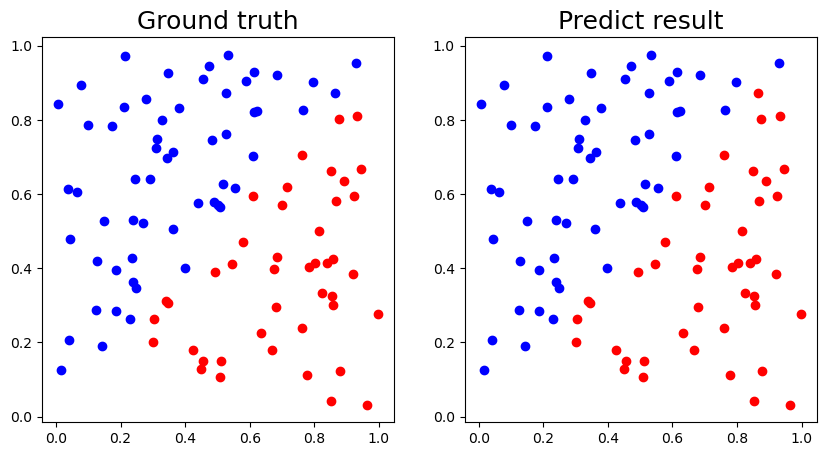

Iter: 0 |	 Ground truth: [1] |	 Predict: [0.99996272]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.9999847]
Iter: 2 |	 Ground truth: [1] |	 Predict: [0.99984966]
Iter: 3 |	 Ground truth: [0] |	 Predict: [8.39298387e-05]
Iter: 4 |	 Ground truth: [1] |	 Predict: [0.99997565]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.8026925]
Iter: 6 |	 Ground truth: [1] |	 Predict: [0.99997551]
Iter: 7 |	 Ground truth: [0] |	 Predict: [0.0001013]
Iter: 8 |	 Ground truth: [1] |	 Predict: [0.99991934]
Iter: 9 |	 Ground truth: [0] |	 Predict: [0.00100229]
Iter: 10 |	 Ground truth: [1] |	 Predict: [0.99997927]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.00011225]
Iter: 12 |	 Ground truth: [0] |	 Predict: [0.00014543]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00103297]
Iter: 14 |	 Ground truth: [0] |	 Predict: [0.14441291]
Iter: 15 |	 Ground truth: [1] |	 Predict: [0.99998048]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99998274]
Iter: 17 |	 Ground truth: [1] |	 Predict: [0.99997845]
Iter: 18 |	 Ground 

In [24]:
loss2 = Traning_and_Test(NN1, generate_linear, lr=0.001)

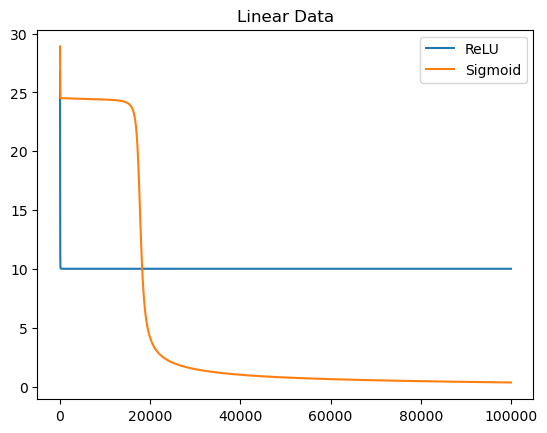

In [25]:
loss_cmp(loss1, loss2, 'ReLU', 'Sigmoid', 'Linear Data')

epoch 0, loss: 216.6796151290044
epoch 5000, loss: 6.062992125984252
epoch 10000, loss: 6.062992125984252
epoch 15000, loss: 6.062992125984252
epoch 20000, loss: 6.062992125984252
epoch 25000, loss: 6.062992125984252
epoch 30000, loss: 6.062992125984252
epoch 35000, loss: 6.062992125984252
epoch 40000, loss: 6.062992125984252
epoch 45000, loss: 6.062992125984252
epoch 50000, loss: 6.062992125984252
epoch 55000, loss: 6.062992125984252
epoch 60000, loss: 6.062992125984252
epoch 65000, loss: 6.062992125984252
epoch 70000, loss: 6.062992125984252
epoch 75000, loss: 6.062992125984252
epoch 80000, loss: 6.062992125984252
epoch 85000, loss: 6.062992125984252
epoch 90000, loss: 6.062992125984252
epoch 95000, loss: 6.062992125984252
epoch 100000, loss: 6.062992125984252


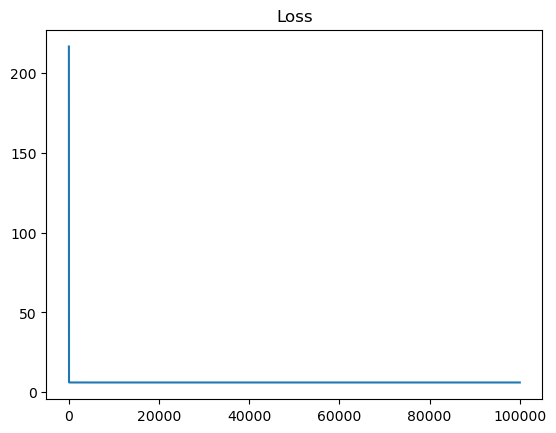

[[0.        ]
 [0.39370079]
 [0.07874016]
 [0.39370079]
 [0.15748031]
 [0.39370079]
 [0.23622047]
 [0.39370079]
 [0.31496063]
 [0.39370079]
 [0.39370079]
 [0.47244094]
 [0.39370079]
 [0.5511811 ]
 [0.39370079]
 [0.62992126]
 [0.39370079]
 [0.70866142]
 [0.39370079]
 [0.78740157]
 [0.39370079]]
Accuracy: 0.3333333333333333


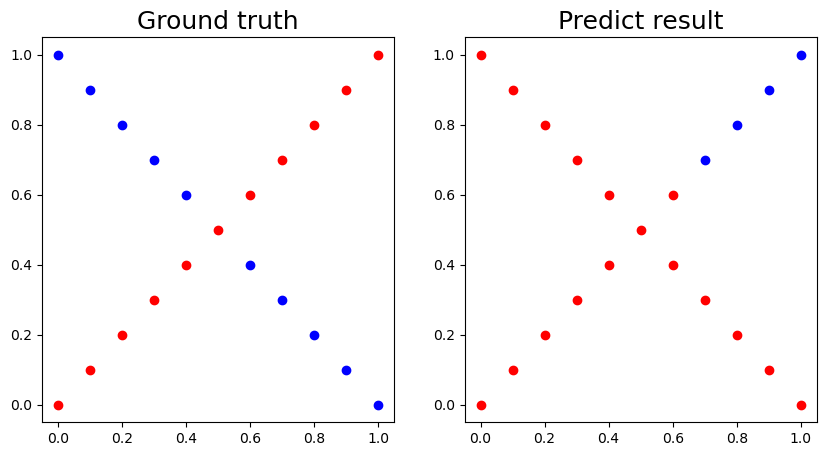

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.07874016]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.15748031]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.23622047]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.31496063]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.39370079]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.47244094]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.5511811]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.62992126]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.39370079]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.70866142]
Iter: 18 |	 Ground truth: [1]

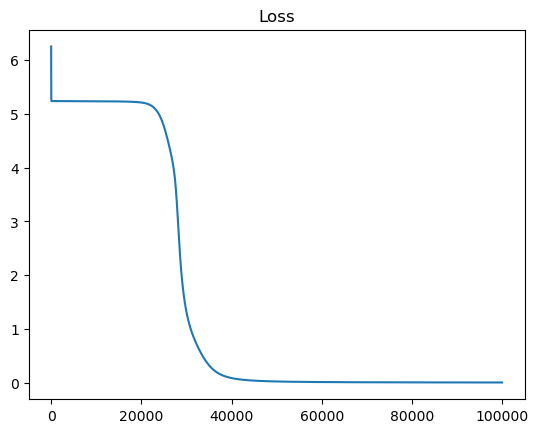

[[2.99625052e-04]
 [9.99818312e-01]
 [1.21699589e-03]
 [9.99807914e-01]
 [5.30203191e-03]
 [9.99779299e-01]
 [1.52290893e-02]
 [9.99592081e-01]
 [2.30313245e-02]
 [9.70226763e-01]
 [2.03737150e-02]
 [1.31557113e-02]
 [9.72762180e-01]
 [7.56349563e-03]
 [9.99501755e-01]
 [4.40163260e-03]
 [9.99589035e-01]
 [2.75357454e-03]
 [9.99469847e-01]
 [1.88125486e-03]
 [9.99227397e-01]]
Accuracy: 1.0


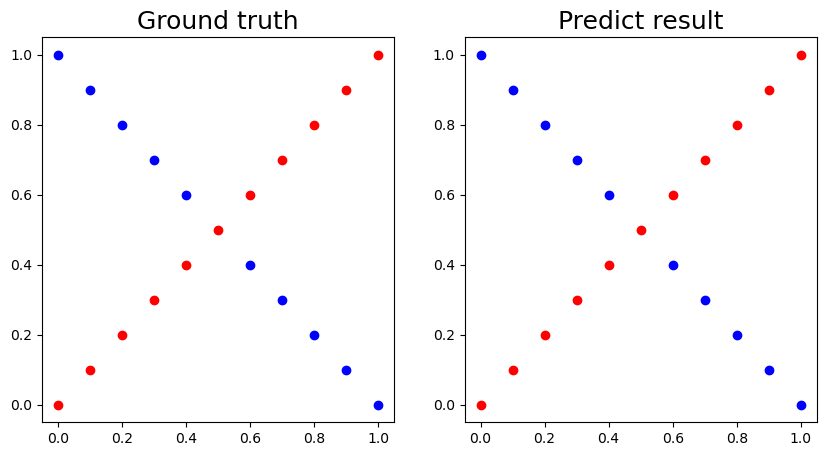

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.00029963]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99981831]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.001217]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99980791]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00530203]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.9997793]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.01522909]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99959208]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.02303132]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.97022676]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.02037371]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.01315571]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.97276218]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.0075635]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99950176]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.00440163]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99958904]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.00275357]
Iter: 18 |	 Ground truth

In [26]:
loss1 = Traning_and_Test(NN_relu, generate_XOR_easy, lr=0.001)
loss2 = Traning_and_Test(NN1, generate_XOR_easy, lr=0.01)

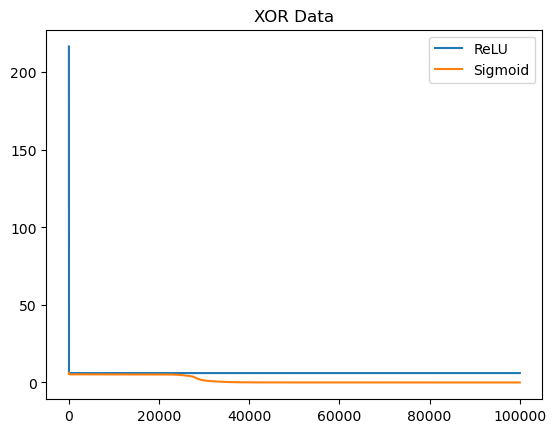

In [27]:
loss_cmp(loss1, loss2, 'ReLU', 'Sigmoid', 'XOR Data')

In [28]:
class NN_adagrad:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.sigmoid1 = Sigmoid()
        self.sigmoid2 = Sigmoid()
        self.sigmoid3 = Sigmoid()
        self.lr = lr
        self.optimizer = Adagrad([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.sigmoid1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.sigmoid2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.sigmoid3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.sigmoid3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.sigmoid2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.sigmoid1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss
    
class NN_momentum:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.sigmoid1 = Sigmoid()
        self.sigmoid2 = Sigmoid()
        self.sigmoid3 = Sigmoid()
        self.lr = lr
        self.optimizer = Momentum([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.sigmoid1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.sigmoid2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.sigmoid3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.sigmoid3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.sigmoid2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.sigmoid1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

epoch 0, loss: 38.62629471538702
epoch 5000, loss: 0.02179804711649005
epoch 10000, loss: 0.006255335080462622
epoch 15000, loss: 0.0033063098125792625
epoch 20000, loss: 0.002164647590141243
epoch 25000, loss: 0.001578768614352118
epoch 30000, loss: 0.001228503176304522
epoch 35000, loss: 0.0009979964351542255
epoch 40000, loss: 0.0008359559515159116
epoch 45000, loss: 0.0007164293355683818
epoch 50000, loss: 0.0006249711866342756
epoch 55000, loss: 0.000552943002038966
epoch 60000, loss: 0.0004948813585777061
epoch 65000, loss: 0.0004471720384986334
epoch 70000, loss: 0.00040733424697529425
epoch 75000, loss: 0.0003736118231642792
epoch 80000, loss: 0.0003447286075078066
epoch 85000, loss: 0.0003197361527261043
epoch 90000, loss: 0.00029791566327670303
epoch 95000, loss: 0.0002787129784556054
epoch 100000, loss: 0.00026169434695732553


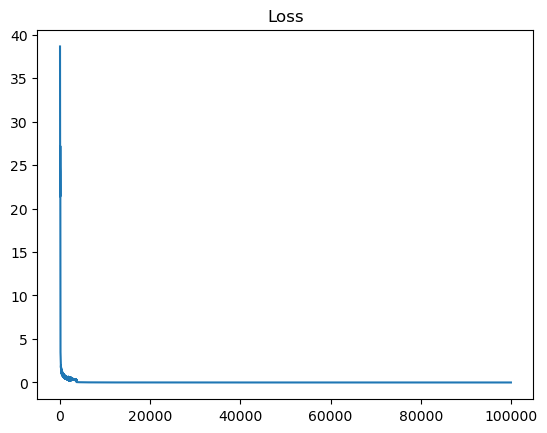

[[9.99999871e-01]
 [9.99999888e-01]
 [9.99999895e-01]
 [9.99999894e-01]
 [9.99999923e-01]
 [9.99999918e-01]
 [9.99999921e-01]
 [1.08031182e-07]
 [9.99999919e-01]
 [9.99999914e-01]
 [9.89793930e-08]
 [1.62704798e-07]
 [7.59241511e-01]
 [5.76472088e-07]
 [9.99999916e-01]
 [8.05884906e-08]
 [8.10985061e-08]
 [9.99999924e-01]
 [9.99999917e-01]
 [9.99999912e-01]
 [8.55132798e-08]
 [1.35384196e-07]
 [1.51817817e-07]
 [9.99999923e-01]
 [8.07433453e-08]
 [9.99999914e-01]
 [9.99999904e-01]
 [1.09573726e-06]
 [9.99999908e-01]
 [7.99581250e-08]
 [1.54667161e-07]
 [9.99999912e-01]
 [7.94831270e-08]
 [4.51991060e-01]
 [1.11165131e-07]
 [9.99999924e-01]
 [9.99999916e-01]
 [1.05675231e-07]
 [8.00910056e-08]
 [8.20532709e-08]
 [1.13354251e-07]
 [9.99999920e-01]
 [9.99999922e-01]
 [9.99999922e-01]
 [8.54398051e-08]
 [5.56134490e-04]
 [9.99999924e-01]
 [7.12874529e-03]
 [9.99999921e-01]
 [3.19839350e-06]
 [9.99999725e-01]
 [9.99999921e-01]
 [9.11905940e-08]
 [6.13111403e-07]
 [9.86109628e-08]
 [9.670423

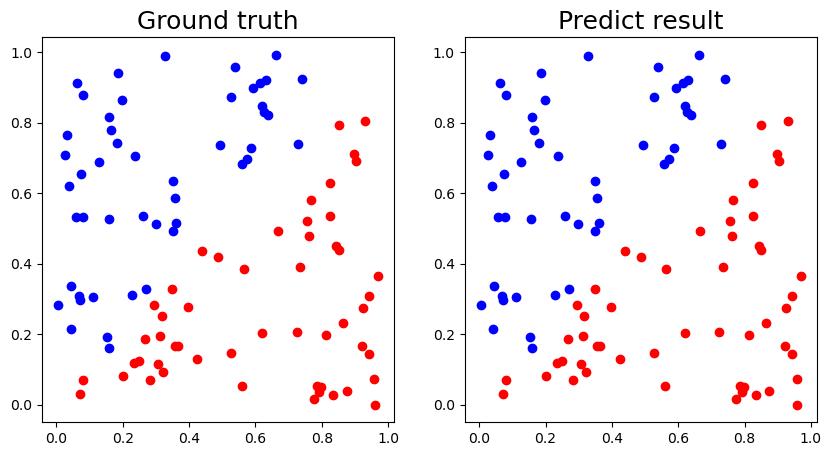

Iter: 0 |	 Ground truth: [1] |	 Predict: [0.99999987]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99999989]
Iter: 2 |	 Ground truth: [1] |	 Predict: [0.99999989]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99999989]
Iter: 4 |	 Ground truth: [1] |	 Predict: [0.99999992]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99999992]
Iter: 6 |	 Ground truth: [1] |	 Predict: [0.99999992]
Iter: 7 |	 Ground truth: [0] |	 Predict: [1.08031182e-07]
Iter: 8 |	 Ground truth: [1] |	 Predict: [0.99999992]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99999991]
Iter: 10 |	 Ground truth: [0] |	 Predict: [9.8979393e-08]
Iter: 11 |	 Ground truth: [0] |	 Predict: [1.62704798e-07]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.75924151]
Iter: 13 |	 Ground truth: [0] |	 Predict: [5.76472088e-07]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99999992]
Iter: 15 |	 Ground truth: [0] |	 Predict: [8.05884906e-08]
Iter: 16 |	 Ground truth: [0] |	 Predict: [8.10985061e-08]
Iter: 17 |	 Ground truth: [1] |	 Predict: [0.9999999

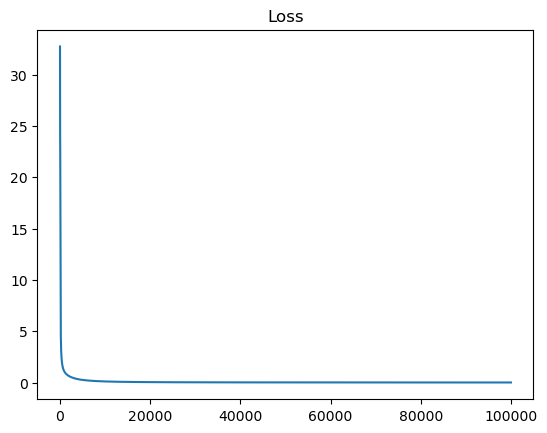

[[3.56137793e-05]
 [2.36683106e-05]
 [2.36674107e-05]
 [9.99976295e-01]
 [2.36647342e-05]
 [2.71942042e-05]
 [2.36654107e-05]
 [2.36682152e-05]
 [2.37295714e-05]
 [9.99975656e-01]
 [2.37903969e-05]
 [2.37194268e-05]
 [9.99911722e-01]
 [9.99976381e-01]
 [9.99976382e-01]
 [2.36643531e-05]
 [9.99967766e-01]
 [9.99974979e-01]
 [9.96926739e-01]
 [1.42730330e-04]
 [3.44291029e-05]
 [9.99976381e-01]
 [2.51667806e-05]
 [9.99976380e-01]
 [2.36893458e-05]
 [2.36648443e-05]
 [2.36643691e-05]
 [9.99975320e-01]
 [2.43562995e-05]
 [9.99976375e-01]
 [2.48600785e-05]
 [9.99976340e-01]
 [9.99976380e-01]
 [2.42058153e-05]
 [2.36789721e-05]
 [2.36643450e-05]
 [9.43324113e-01]
 [6.61992292e-05]
 [2.36658367e-05]
 [2.36643483e-05]
 [2.12215216e-04]
 [9.99976382e-01]
 [2.36647919e-05]
 [9.99976377e-01]
 [2.36842447e-05]
 [2.37020066e-05]
 [9.99975524e-01]
 [9.92401113e-01]
 [7.59887202e-02]
 [9.99976184e-01]
 [9.99976380e-01]
 [2.37071900e-05]
 [2.36775034e-05]
 [2.36648819e-05]
 [9.99976372e-01]
 [2.366441

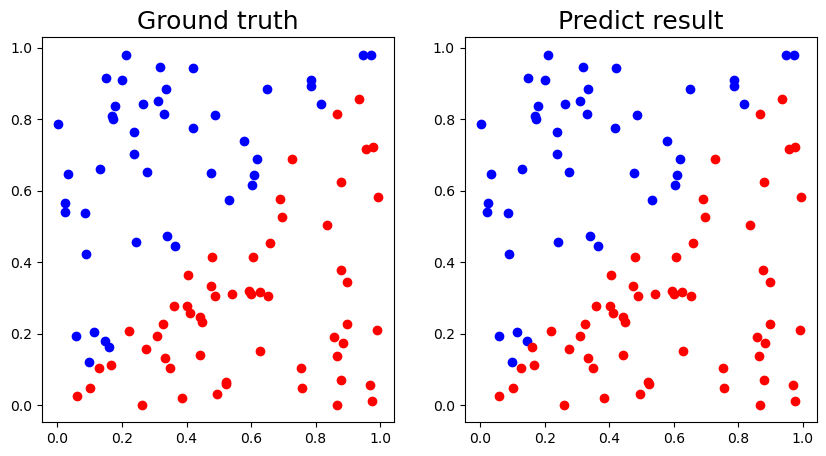

Iter: 0 |	 Ground truth: [0] |	 Predict: [3.56137793e-05]
Iter: 1 |	 Ground truth: [0] |	 Predict: [2.36683106e-05]
Iter: 2 |	 Ground truth: [0] |	 Predict: [2.36674107e-05]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.9999763]
Iter: 4 |	 Ground truth: [0] |	 Predict: [2.36647342e-05]
Iter: 5 |	 Ground truth: [0] |	 Predict: [2.71942042e-05]
Iter: 6 |	 Ground truth: [0] |	 Predict: [2.36654107e-05]
Iter: 7 |	 Ground truth: [0] |	 Predict: [2.36682152e-05]
Iter: 8 |	 Ground truth: [0] |	 Predict: [2.37295714e-05]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99997566]
Iter: 10 |	 Ground truth: [0] |	 Predict: [2.37903969e-05]
Iter: 11 |	 Ground truth: [0] |	 Predict: [2.37194268e-05]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99991172]
Iter: 13 |	 Ground truth: [1] |	 Predict: [0.99997638]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99997638]
Iter: 15 |	 Ground truth: [0] |	 Predict: [2.36643531e-05]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99996777]
Iter: 17 |	 Ground truth: [1] |	

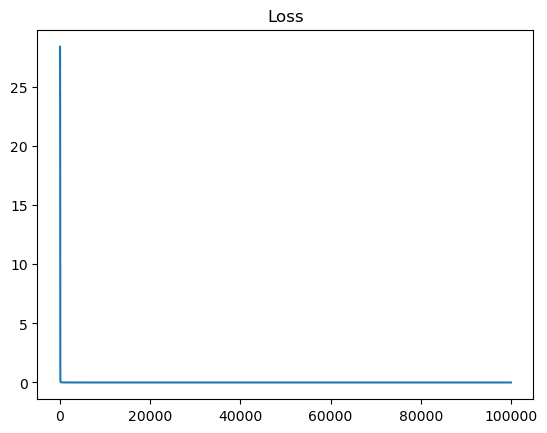

[[8.57136770e-09]
 [6.61271369e-11]
 [9.99999999e-01]
 [9.99999999e-01]
 [1.15044206e-10]
 [6.69390762e-11]
 [9.99999948e-01]
 [6.62056162e-11]
 [7.30694845e-11]
 [9.99999999e-01]
 [6.93680210e-11]
 [9.99979323e-01]
 [9.99999999e-01]
 [6.78591461e-11]
 [2.28056734e-06]
 [2.01275905e-10]
 [8.65012382e-11]
 [1.23658610e-10]
 [9.99999997e-01]
 [6.66826459e-11]
 [7.51687488e-11]
 [6.64224280e-11]
 [9.99999999e-01]
 [9.99999987e-01]
 [9.99516455e-01]
 [9.99999999e-01]
 [7.86450560e-11]
 [1.16353884e-10]
 [9.99999999e-01]
 [6.61369636e-11]
 [9.99999999e-01]
 [6.60767355e-09]
 [9.99999999e-01]
 [6.72800894e-11]
 [4.26851049e-10]
 [9.99999999e-01]
 [6.60892140e-11]
 [7.21763407e-01]
 [6.77973060e-11]
 [6.77013390e-11]
 [8.62316569e-11]
 [9.99999999e-01]
 [6.61411808e-11]
 [9.99999999e-01]
 [9.99999999e-01]
 [9.99999996e-01]
 [6.64483429e-11]
 [9.99952456e-01]
 [9.99999999e-01]
 [7.09114510e-11]
 [6.71057200e-11]
 [6.82094806e-11]
 [9.99999999e-01]
 [8.34502081e-10]
 [6.95315885e-11]
 [9.999999

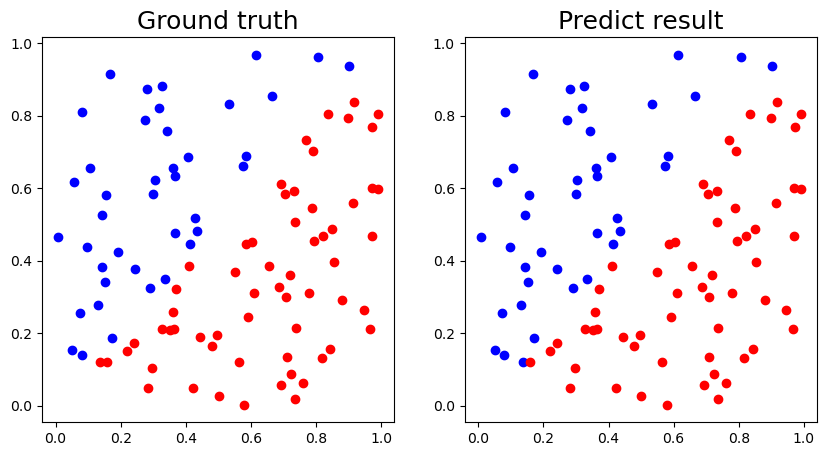

Iter: 0 |	 Ground truth: [0] |	 Predict: [8.5713677e-09]
Iter: 1 |	 Ground truth: [0] |	 Predict: [6.61271369e-11]
Iter: 2 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 3 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 4 |	 Ground truth: [0] |	 Predict: [1.15044206e-10]
Iter: 5 |	 Ground truth: [0] |	 Predict: [6.69390762e-11]
Iter: 6 |	 Ground truth: [1] |	 Predict: [0.99999995]
Iter: 7 |	 Ground truth: [0] |	 Predict: [6.62056162e-11]
Iter: 8 |	 Ground truth: [0] |	 Predict: [7.30694845e-11]
Iter: 9 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 10 |	 Ground truth: [0] |	 Predict: [6.9368021e-11]
Iter: 11 |	 Ground truth: [1] |	 Predict: [0.99997932]
Iter: 12 |	 Ground truth: [1] |	 Predict: [1.]
Iter: 13 |	 Ground truth: [0] |	 Predict: [6.78591461e-11]
Iter: 14 |	 Ground truth: [0] |	 Predict: [2.28056734e-06]
Iter: 15 |	 Ground truth: [0] |	 Predict: [2.01275905e-10]
Iter: 16 |	 Ground truth: [0] |	 Predict: [8.65012382e-11]
Iter: 17 |	 Ground truth: [0] |	 Predict: [1.2365861e-10]
Iter: 1

In [29]:
loss1 = Traning_and_Test(NN1, generate_linear, lr=0.1)
loss2 = Traning_and_Test(NN_adagrad, generate_linear, lr=0.1)
loss3 = Traning_and_Test(NN_momentum, generate_linear, lr=0.1)

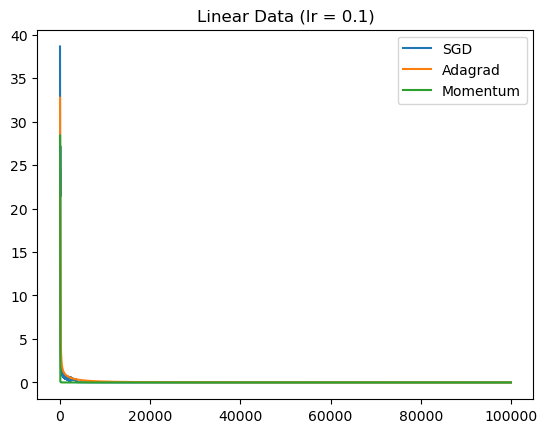

In [30]:
plt.title('Linear Data (lr = 0.1)')
plt.plot(loss1, label='SGD')
plt.plot(loss2, label='Adagrad')
plt.plot(loss3, label='Momentum')
plt.legend()
plt.show()

epoch 0, loss: 7.8964997137057775
epoch 5000, loss: 0.018835425805936282
epoch 10000, loss: 0.0031345588594567904
epoch 15000, loss: 0.0015687689655288915
epoch 20000, loss: 0.0010201170028265312
epoch 25000, loss: 0.0007469083796781876
epoch 30000, loss: 0.0005851641278451486
epoch 35000, loss: 0.0004789288093714607
epoch 40000, loss: 0.0004041340330182123
epoch 45000, loss: 0.00034878815200862357
epoch 50000, loss: 0.00030627222210740393
epoch 55000, loss: 0.0002726453318413677
epoch 60000, loss: 0.0002454198986927335
epoch 65000, loss: 0.00022295099142716026
epoch 70000, loss: 0.0002041088722349189
epoch 75000, loss: 0.000188092803309727
epoch 80000, loss: 0.0001743199294124883
epoch 85000, loss: 0.00016235621495747958
epoch 90000, loss: 0.00015187200684783548
epoch 95000, loss: 0.00014261257504735275
epoch 100000, loss: 0.0001343780670499782


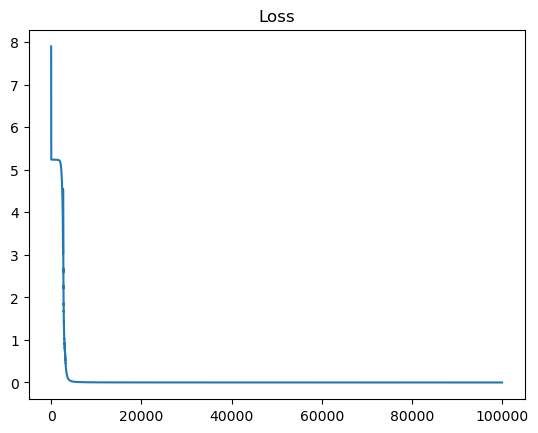

[[1.40022011e-04]
 [9.99878271e-01]
 [4.62599132e-04]
 [9.99881274e-01]
 [1.57647071e-03]
 [9.99880808e-01]
 [3.68925713e-03]
 [9.99848188e-01]
 [4.80921840e-03]
 [9.94009807e-01]
 [3.81734743e-03]
 [2.30195542e-03]
 [9.93959091e-01]
 [1.28689896e-03]
 [9.99869030e-01]
 [7.50959692e-04]
 [9.99903645e-01]
 [4.79399943e-04]
 [9.99908190e-01]
 [3.36566304e-04]
 [9.99909830e-01]]
Accuracy: 1.0


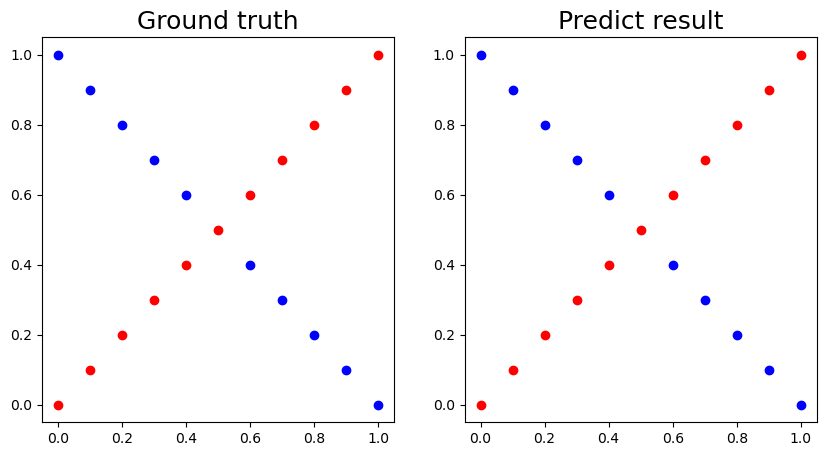

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.00014002]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99987827]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.0004626]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99988127]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00157647]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99988081]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.00368926]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99984819]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.00480922]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99400981]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.00381735]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.00230196]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99395909]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.0012869]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99986903]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.00075096]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99990364]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.0004794]
Iter: 18 |	 Ground trut

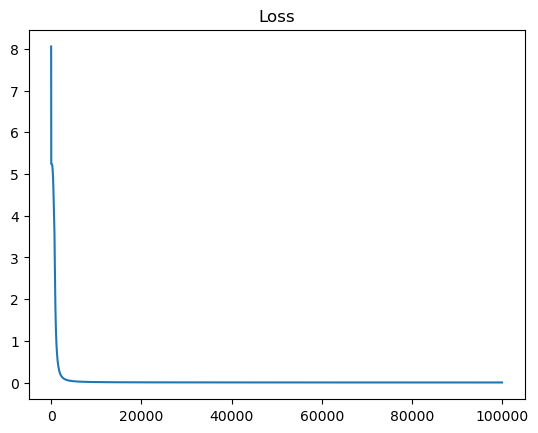

[[0.00379295]
 [0.99950518]
 [0.00533698]
 [0.99948468]
 [0.00718745]
 [0.99944365]
 [0.00830161]
 [0.99925706]
 [0.00793055]
 [0.98846479]
 [0.00653041]
 [0.00499169]
 [0.99138049]
 [0.00377916]
 [0.99964829]
 [0.00294555]
 [0.9996069 ]
 [0.00239927]
 [0.99931826]
 [0.00204363]
 [0.99860571]]
Accuracy: 1.0


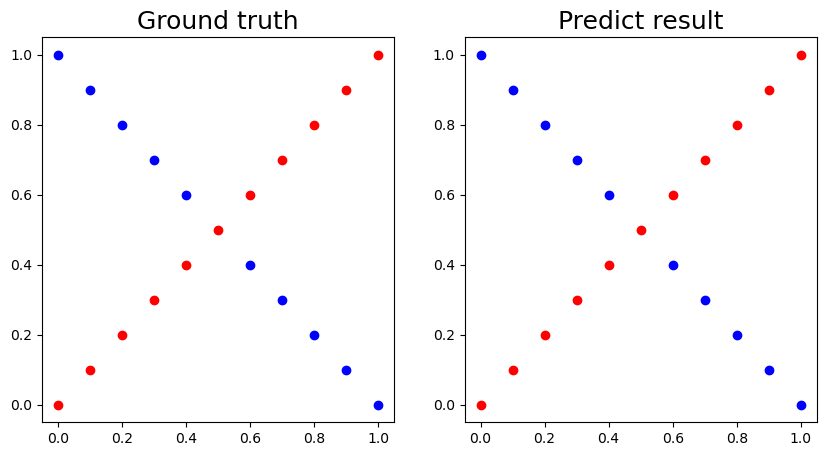

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.00379295]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99950518]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.00533698]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99948468]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00718745]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99944365]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.00830161]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99925706]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.00793055]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.98846479]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.00653041]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.00499169]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99138049]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00377916]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99964829]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.00294555]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.9996069]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.00239927]
Iter: 18 |	 Ground tr

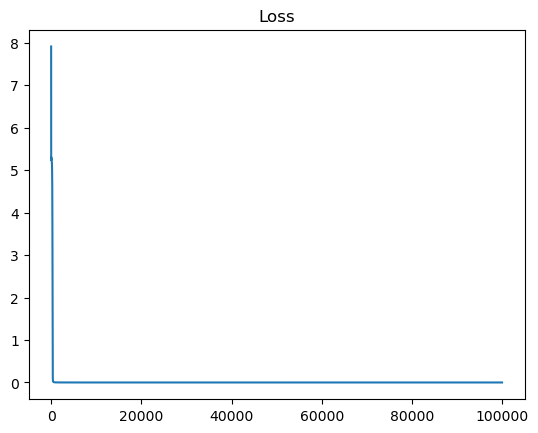

[[1.26161686e-04]
 [9.99993146e-01]
 [3.60532966e-04]
 [9.99993340e-01]
 [7.97841396e-04]
 [9.99993305e-01]
 [1.12150416e-03]
 [9.99990638e-01]
 [9.72753245e-04]
 [9.98541153e-01]
 [5.82021041e-04]
 [2.84298196e-04]
 [9.98507168e-01]
 [1.31942354e-04]
 [9.99991026e-01]
 [6.42948496e-05]
 [9.99994337e-01]
 [3.45202901e-05]
 [9.99994752e-01]
 [2.06751589e-05]
 [9.99994910e-01]]
Accuracy: 1.0


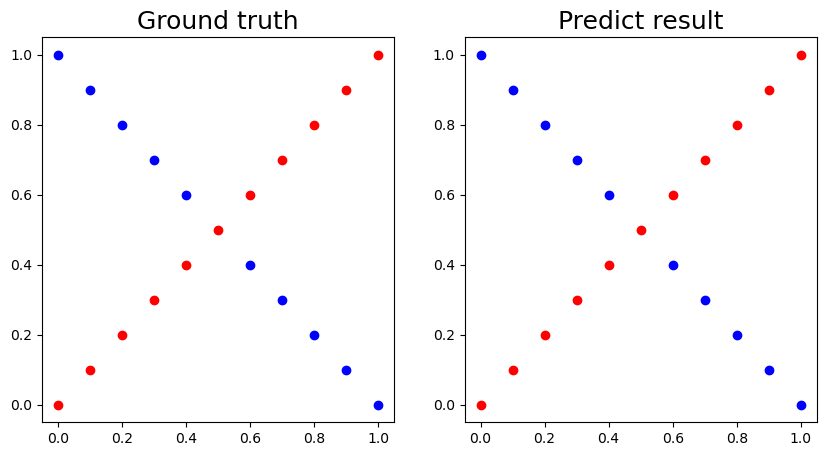

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.00012616]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99999315]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.00036053]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99999334]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00079784]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99999331]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.0011215]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99999064]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.00097275]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99854115]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.00058202]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.0002843]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99850717]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00013194]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99999103]
Iter: 15 |	 Ground truth: [0] |	 Predict: [6.42948496e-05]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99999434]
Iter: 17 |	 Ground truth: [0] |	 Predict: [3.45202901e-05]
Iter: 18 |	 Gr

In [31]:
loss1 = Traning_and_Test(NN1, generate_XOR_easy, lr=0.1)
loss2 = Traning_and_Test(NN_adagrad, generate_XOR_easy, lr=0.1)
loss3 = Traning_and_Test(NN_momentum, generate_XOR_easy, lr=0.1)

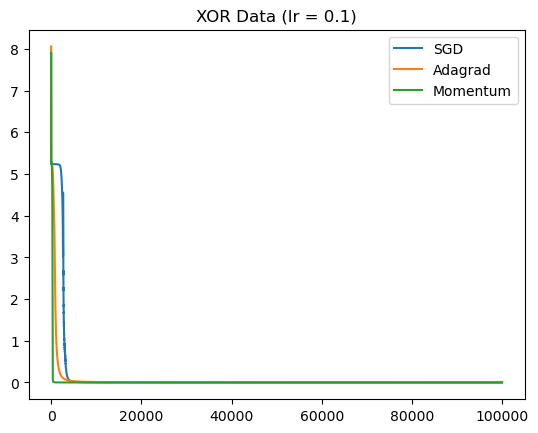

In [32]:
plt.title('XOR Data (lr = 0.1)')
plt.plot(loss1, label='SGD')
plt.plot(loss2, label='Adagrad')
plt.plot(loss3, label='Momentum')
plt.legend()
plt.show()

epoch 0, loss: 36.92034961495806
epoch 5000, loss: 24.744808444236803
epoch 10000, loss: 4.945796128743271
epoch 15000, loss: 2.377781837650901
epoch 20000, loss: 1.7492795556271277
epoch 25000, loss: 1.4268707354391839
epoch 30000, loss: 1.2195420023828052
epoch 35000, loss: 1.0723343720357783
epoch 40000, loss: 0.9611534120413608
epoch 45000, loss: 0.8732657263374733
epoch 50000, loss: 0.8012867906873344
epoch 55000, loss: 0.7406698920826723
epoch 60000, loss: 0.6884835253947718
epoch 65000, loss: 0.6427638614465869
epoch 70000, loss: 0.6021516266537165
epoch 75000, loss: 0.5656789512121156
epoch 80000, loss: 0.5326392165371463
epoch 85000, loss: 0.5025047578611191
epoch 90000, loss: 0.4748731546130568
epoch 95000, loss: 0.4494311157931102
epoch 100000, loss: 0.4259294753676977


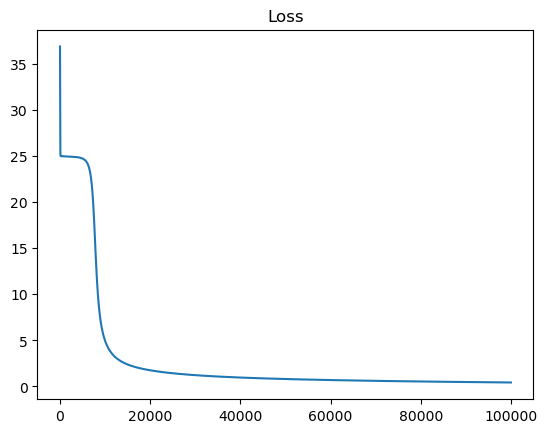

[[9.99962378e-01]
 [1.36747393e-05]
 [9.99967752e-01]
 [6.28336568e-06]
 [9.99941436e-01]
 [9.52456594e-06]
 [9.99967294e-01]
 [9.99970053e-01]
 [3.42855577e-05]
 [9.99970523e-01]
 [8.81578056e-06]
 [1.15808051e-05]
 [9.98828427e-01]
 [9.99969226e-01]
 [2.85075803e-05]
 [9.99972236e-01]
 [9.99972320e-01]
 [9.99089005e-01]
 [6.35288931e-06]
 [9.99962924e-01]
 [9.99972786e-01]
 [1.05743779e-05]
 [7.46574854e-04]
 [6.60561558e-06]
 [9.99970091e-01]
 [1.03299958e-05]
 [9.99968739e-01]
 [9.94958407e-01]
 [6.33872224e-06]
 [1.02493492e-05]
 [7.18344904e-06]
 [6.43705123e-06]
 [5.90242268e-05]
 [9.99954955e-01]
 [1.37588607e-05]
 [9.99970610e-01]
 [9.99969073e-01]
 [9.99966635e-01]
 [9.99967357e-01]
 [3.19226719e-04]
 [9.99947598e-01]
 [2.27199609e-05]
 [9.99971939e-01]
 [9.99972478e-01]
 [6.26862583e-06]
 [9.99436868e-01]
 [9.99827925e-01]
 [1.39793014e-02]
 [9.99961865e-01]
 [5.69825011e-01]
 [9.73706550e-01]
 [9.99969303e-01]
 [6.25254786e-06]
 [9.99959284e-01]
 [6.94867071e-06]
 [9.999625

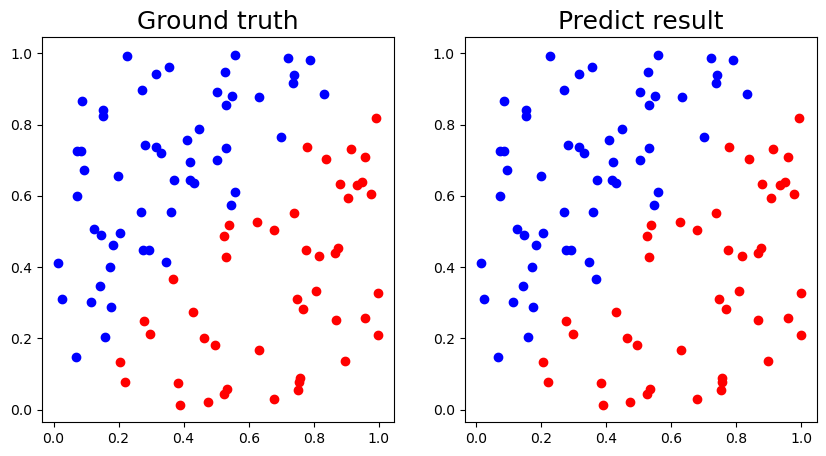

Iter: 0 |	 Ground truth: [1] |	 Predict: [0.99996238]
Iter: 1 |	 Ground truth: [0] |	 Predict: [1.36747393e-05]
Iter: 2 |	 Ground truth: [1] |	 Predict: [0.99996775]
Iter: 3 |	 Ground truth: [0] |	 Predict: [6.28336568e-06]
Iter: 4 |	 Ground truth: [1] |	 Predict: [0.99994144]
Iter: 5 |	 Ground truth: [0] |	 Predict: [9.52456594e-06]
Iter: 6 |	 Ground truth: [1] |	 Predict: [0.99996729]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99997005]
Iter: 8 |	 Ground truth: [0] |	 Predict: [3.42855577e-05]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99997052]
Iter: 10 |	 Ground truth: [0] |	 Predict: [8.81578056e-06]
Iter: 11 |	 Ground truth: [0] |	 Predict: [1.15808051e-05]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99882843]
Iter: 13 |	 Ground truth: [1] |	 Predict: [0.99996923]
Iter: 14 |	 Ground truth: [0] |	 Predict: [2.85075803e-05]
Iter: 15 |	 Ground truth: [1] |	 Predict: [0.99997224]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99997232]
Iter: 17 |	 Ground truth: [1] |	 Predict: [0.99

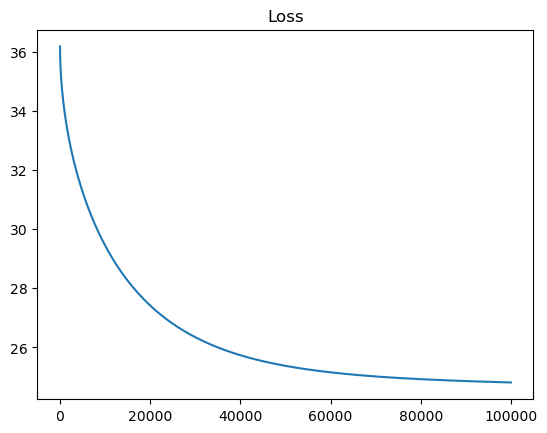

[[0.54771001]
 [0.54708125]
 [0.54281762]
 [0.54326115]
 [0.54338007]
 [0.5426016 ]
 [0.53987746]
 [0.54589054]
 [0.54432665]
 [0.54254434]
 [0.54181189]
 [0.54215416]
 [0.54451453]
 [0.5419843 ]
 [0.54117884]
 [0.54489713]
 [0.54741564]
 [0.54472955]
 [0.5403126 ]
 [0.54329936]
 [0.5452649 ]
 [0.54057205]
 [0.54462435]
 [0.54145182]
 [0.54539841]
 [0.54818855]
 [0.54531233]
 [0.54424012]
 [0.54423757]
 [0.5463309 ]
 [0.54184048]
 [0.54774936]
 [0.54399298]
 [0.5454004 ]
 [0.54741316]
 [0.54821   ]
 [0.54313513]
 [0.54472598]
 [0.5426487 ]
 [0.54714582]
 [0.54364075]
 [0.54306378]
 [0.54142958]
 [0.54518948]
 [0.53926473]
 [0.54588054]
 [0.54266527]
 [0.54814964]
 [0.54321452]
 [0.54450484]
 [0.54282435]
 [0.54114932]
 [0.54269059]
 [0.54631374]
 [0.5472936 ]
 [0.54226171]
 [0.54251348]
 [0.54314043]
 [0.54894137]
 [0.54233418]
 [0.54305787]
 [0.54392022]
 [0.5399748 ]
 [0.54524006]
 [0.54635042]
 [0.54328917]
 [0.54449462]
 [0.54551489]
 [0.54430499]
 [0.54036653]
 [0.54084572]
 [0.54

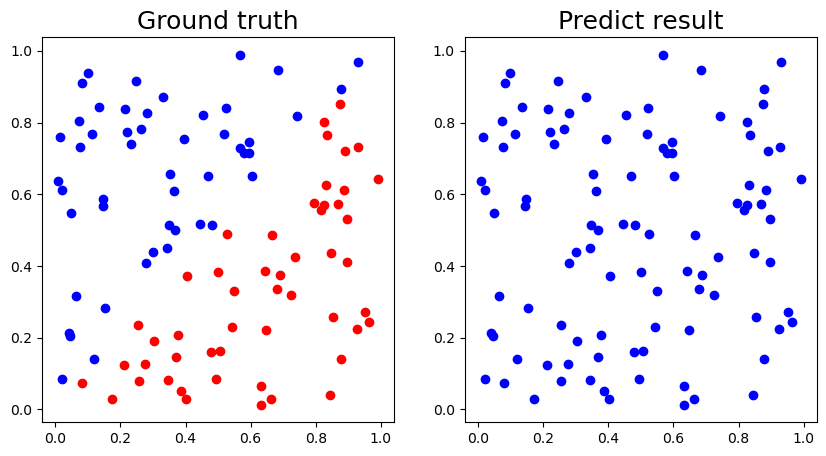

Iter: 0 |	 Ground truth: [1] |	 Predict: [0.54771001]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.54708125]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.54281762]
Iter: 3 |	 Ground truth: [0] |	 Predict: [0.54326115]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.54338007]
Iter: 5 |	 Ground truth: [0] |	 Predict: [0.5426016]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.53987746]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.54589054]
Iter: 8 |	 Ground truth: [1] |	 Predict: [0.54432665]
Iter: 9 |	 Ground truth: [0] |	 Predict: [0.54254434]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.54181189]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.54215416]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.54451453]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.5419843]
Iter: 14 |	 Ground truth: [0] |	 Predict: [0.54117884]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.54489713]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.54741564]
Iter: 17 |	 Ground truth: [1] |	 Predict: [0.54472955]
Iter: 18 |	 Ground tru

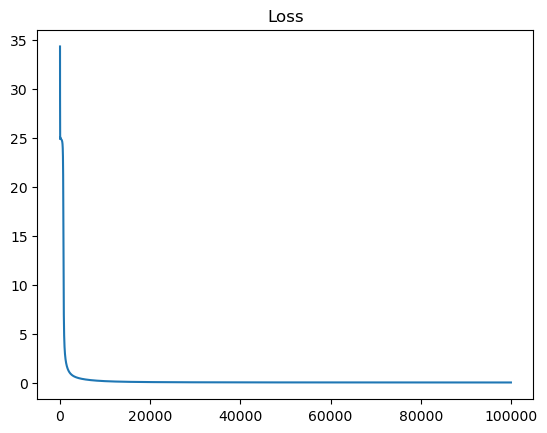

[[7.05272070e-02]
 [9.99999680e-01]
 [5.33817688e-07]
 [9.99999661e-01]
 [9.99985200e-01]
 [9.99999680e-01]
 [9.99999719e-01]
 [9.99999684e-01]
 [5.11596540e-07]
 [9.99999694e-01]
 [9.99999652e-01]
 [9.99999661e-01]
 [9.99999639e-01]
 [1.08842210e-03]
 [5.02418487e-07]
 [9.99999693e-01]
 [1.06163238e-06]
 [9.99999692e-01]
 [9.99999720e-01]
 [9.99999698e-01]
 [9.99999425e-01]
 [4.85210399e-06]
 [7.68258618e-07]
 [4.71940894e-07]
 [9.99674530e-01]
 [5.45034964e-07]
 [4.75220218e-07]
 [4.99523927e-07]
 [5.03747175e-07]
 [4.70251106e-07]
 [7.13608975e-01]
 [9.99999704e-01]
 [1.48121538e-06]
 [1.87104792e-06]
 [4.81822688e-07]
 [9.99999655e-01]
 [9.99999709e-01]
 [4.96400974e-07]
 [5.69003961e-07]
 [5.40142502e-07]
 [9.99917590e-01]
 [4.74353788e-07]
 [5.04253746e-07]
 [4.72485926e-07]
 [5.56528338e-07]
 [1.73553353e-06]
 [5.47640896e-06]
 [5.05232149e-07]
 [9.99999713e-01]
 [9.99998546e-01]
 [9.99999702e-01]
 [9.99999721e-01]
 [9.99999673e-01]
 [6.07267329e-07]
 [4.76843876e-07]
 [1.573845

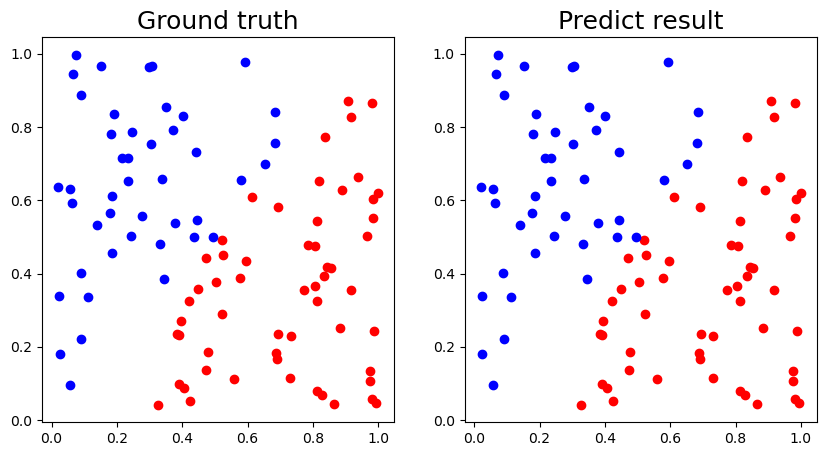

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.07052721]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99999968]
Iter: 2 |	 Ground truth: [0] |	 Predict: [5.33817688e-07]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.99999966]
Iter: 4 |	 Ground truth: [1] |	 Predict: [0.9999852]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99999968]
Iter: 6 |	 Ground truth: [1] |	 Predict: [0.99999972]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99999968]
Iter: 8 |	 Ground truth: [0] |	 Predict: [5.1159654e-07]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.99999969]
Iter: 10 |	 Ground truth: [1] |	 Predict: [0.99999965]
Iter: 11 |	 Ground truth: [1] |	 Predict: [0.99999966]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.99999964]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00108842]
Iter: 14 |	 Ground truth: [0] |	 Predict: [5.02418487e-07]
Iter: 15 |	 Ground truth: [1] |	 Predict: [0.99999969]
Iter: 16 |	 Ground truth: [0] |	 Predict: [1.06163238e-06]
Iter: 17 |	 Ground truth: [1] |	 Predict: [0.99999969]
Iter: 

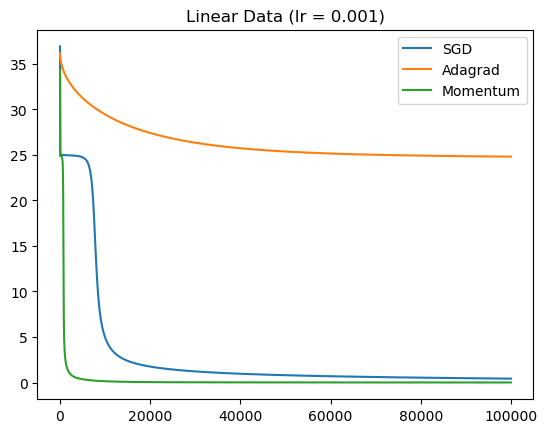

In [33]:
loss1 = Traning_and_Test(NN1, generate_linear, lr=0.001)
loss2 = Traning_and_Test(NN_adagrad, generate_linear, lr=0.001)
loss3 = Traning_and_Test(NN_momentum, generate_linear, lr=0.001)
plt.title('Linear Data (lr = 0.001)')
plt.plot(loss1, label='SGD')
plt.plot(loss2, label='Adagrad')
plt.plot(loss3, label='Momentum')
plt.legend()
plt.show()

epoch 0, loss: 9.146589483001913
epoch 5000, loss: 5.238723938052464
epoch 10000, loss: 5.238678247216803
epoch 15000, loss: 5.2386339349101885
epoch 20000, loss: 5.238590865881366
epoch 25000, loss: 5.238548910795563
epoch 30000, loss: 5.238507945541491
epoch 35000, loss: 5.238467850568381
epoch 40000, loss: 5.238428510248115
epoch 45000, loss: 5.238389812257679
epoch 50000, loss: 5.23835164697718
epoch 55000, loss: 5.238313906898725
epoch 60000, loss: 5.238276486041355
epoch 65000, loss: 5.23823927936716
epoch 70000, loss: 5.238202182193465
epoch 75000, loss: 5.238165089595779
epoch 80000, loss: 5.238127895795809
epoch 85000, loss: 5.238090493528421
epoch 90000, loss: 5.238052773380961
epoch 95000, loss: 5.23801462309756
epoch 100000, loss: 5.237975926840408


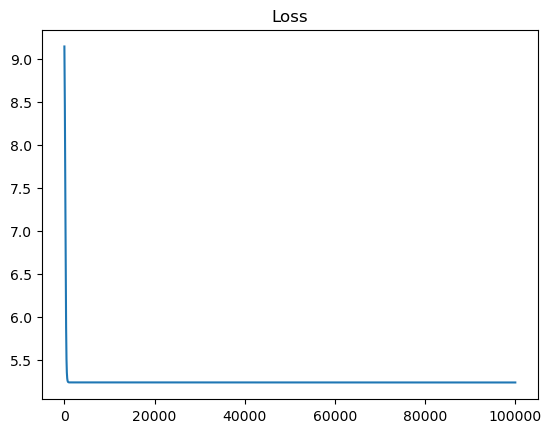

[[0.47714924]
 [0.47617473]
 [0.47703853]
 [0.47625029]
 [0.47692424]
 [0.47632716]
 [0.47680683]
 [0.47640525]
 [0.4766868 ]
 [0.47648447]
 [0.47656475]
 [0.4764413 ]
 [0.47664596]
 [0.47631713]
 [0.47672799]
 [0.47619288]
 [0.47681073]
 [0.47606919]
 [0.47689406]
 [0.47594665]
 [0.47697783]]
Accuracy: 0.5238095238095238


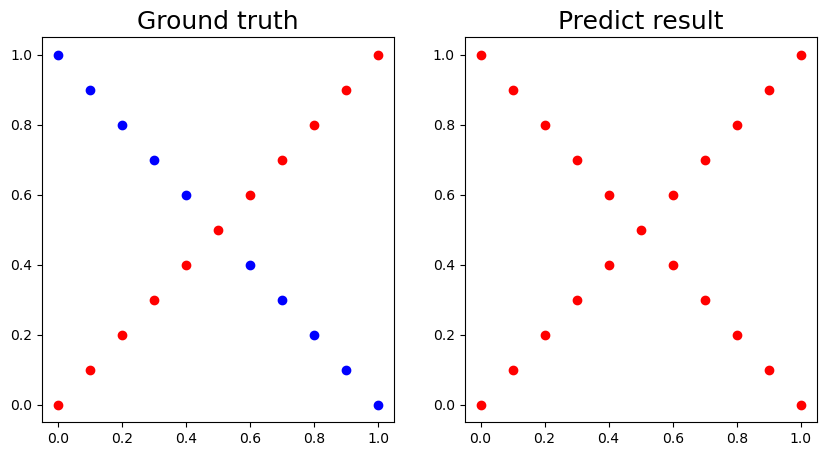

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.47714924]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.47617473]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.47703853]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.47625029]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.47692424]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.47632716]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.47680683]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.47640525]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.4766868]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.47648447]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.47656475]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.4764413]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.47664596]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.47631713]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.47672799]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.47619288]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.47681073]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.47606919]
Iter: 18 |	 Ground tru

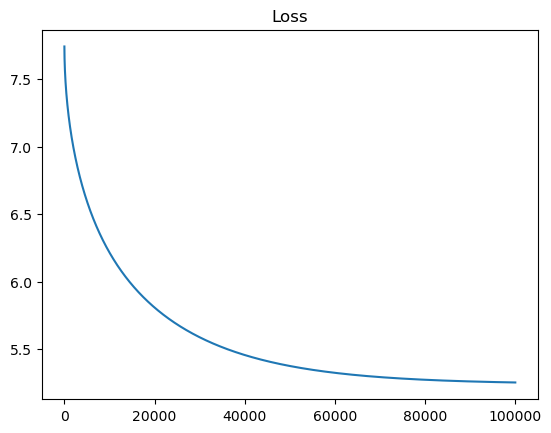

[[0.50426958]
 [0.4992357 ]
 [0.50356663]
 [0.49956576]
 [0.50288469]
 [0.49990719]
 [0.50222734]
 [0.50025987]
 [0.50159769]
 [0.50062363]
 [0.50099826]
 [0.50043099]
 [0.50138348]
 [0.49989723]
 [0.50177896]
 [0.49939774]
 [0.50218434]
 [0.49893274]
 [0.50259918]
 [0.49850196]
 [0.50302301]]
Accuracy: 0.5238095238095238


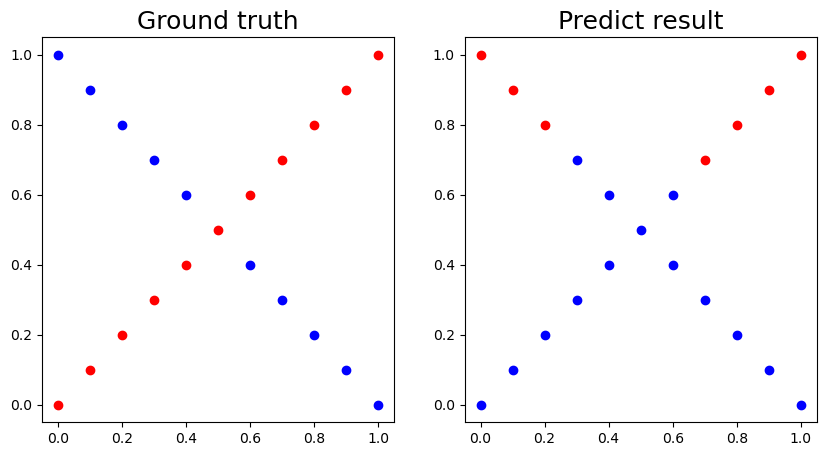

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.50426958]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.4992357]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.50356663]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.49956576]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.50288469]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.49990719]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.50222734]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.50025987]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.50159769]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.50062363]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.50099826]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.50043099]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.50138348]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.49989723]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.50177896]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.49939774]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.50218434]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.49893274]
Iter: 18 |	 Ground tr

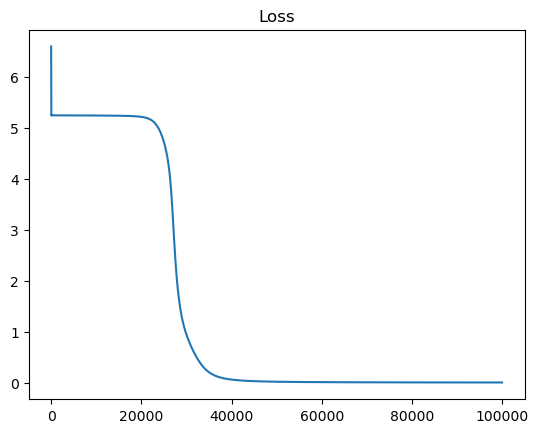

[[1.82716658e-04]
 [9.99901886e-01]
 [1.00905277e-03]
 [9.99922695e-01]
 [5.05320613e-03]
 [9.99930736e-01]
 [1.47602462e-02]
 [9.99873535e-01]
 [2.19221959e-02]
 [9.73961271e-01]
 [1.87849475e-02]
 [1.14480847e-02]
 [9.72941298e-01]
 [6.00791752e-03]
 [9.99896780e-01]
 [3.10814837e-03]
 [9.99962670e-01]
 [1.70818992e-03]
 [9.99970457e-01]
 [1.02735216e-03]
 [9.99973266e-01]]
Accuracy: 1.0


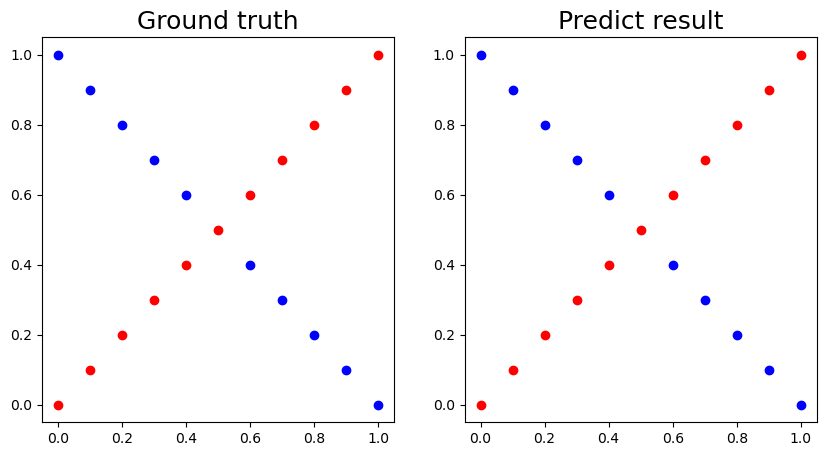

Iter: 0 |	 Ground truth: [0] |	 Predict: [0.00018272]
Iter: 1 |	 Ground truth: [1] |	 Predict: [0.99990189]
Iter: 2 |	 Ground truth: [0] |	 Predict: [0.00100905]
Iter: 3 |	 Ground truth: [1] |	 Predict: [0.9999227]
Iter: 4 |	 Ground truth: [0] |	 Predict: [0.00505321]
Iter: 5 |	 Ground truth: [1] |	 Predict: [0.99993074]
Iter: 6 |	 Ground truth: [0] |	 Predict: [0.01476025]
Iter: 7 |	 Ground truth: [1] |	 Predict: [0.99987354]
Iter: 8 |	 Ground truth: [0] |	 Predict: [0.0219222]
Iter: 9 |	 Ground truth: [1] |	 Predict: [0.97396127]
Iter: 10 |	 Ground truth: [0] |	 Predict: [0.01878495]
Iter: 11 |	 Ground truth: [0] |	 Predict: [0.01144808]
Iter: 12 |	 Ground truth: [1] |	 Predict: [0.9729413]
Iter: 13 |	 Ground truth: [0] |	 Predict: [0.00600792]
Iter: 14 |	 Ground truth: [1] |	 Predict: [0.99989678]
Iter: 15 |	 Ground truth: [0] |	 Predict: [0.00310815]
Iter: 16 |	 Ground truth: [1] |	 Predict: [0.99996267]
Iter: 17 |	 Ground truth: [0] |	 Predict: [0.00170819]
Iter: 18 |	 Ground trut

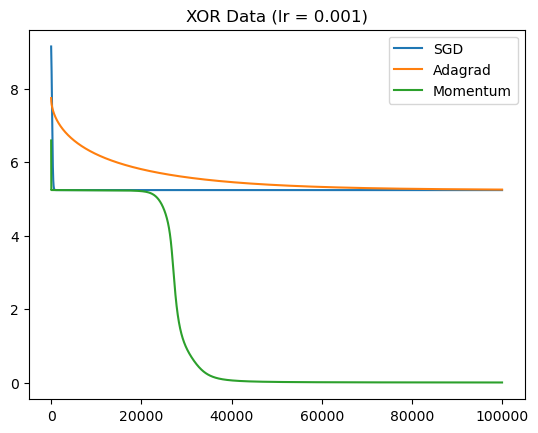

In [34]:
loss1 = Traning_and_Test(NN1, generate_XOR_easy, lr=0.001)
loss2 = Traning_and_Test(NN_adagrad, generate_XOR_easy, lr=0.001)
loss3 = Traning_and_Test(NN_momentum, generate_XOR_easy, lr=0.001)
plt.title('XOR Data (lr = 0.001)')
plt.plot(loss1, label='SGD')
plt.plot(loss2, label='Adagrad')
plt.plot(loss3, label='Momentum')
plt.legend()
plt.show()

In [35]:
class NN_Conv:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Conv1d(self.n_hidden, 1)
        self.weights3 = Linear(3, 1)
        self.sigmoid1 = Sigmoid()
        self.sigmoid2 = Sigmoid()
        self.sigmoid3 = Sigmoid()
        self.lr = lr
        self.optimizer = SGD([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.sigmoid1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.sigmoid2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.sigmoid3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        y = y.reshape(-1, 1)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.sigmoid3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.sigmoid2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.sigmoid1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

In [36]:
Traning_and_Test(NN_Conv, generate_linear)

ValueError: operands could not be broadcast together with shapes (100,2) (4,) (100,2) 